In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net
import json
from os import listdir

import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import hammer_bundle

In [3]:
pd.options.display.max_columns = None

Load the JSON files 

In [3]:
def load_data(directory):
    # Load json files 
    json_data_asctb = {}
    for filename in listdir(directory):
        if '.json' in filename:
            # print(filename)
            with open(f'{directory}{filename}', encoding='utf8') as json_file:
                data = json.load(json_file)

            json_data_asctb[filename[:-5]] = data
    return json_data_asctb

In [4]:
json_data_asctb=load_data('./asct+b/v14/')

Order of the organs

In [5]:
organ_order = ['trachea', 'main_bronchus', 'lung', 'heart', 'spinal_cord', 'brain', 'eye', 'skin',
               'thymus', 'lymph_nodes', 'spleen', 'liver', 'pancreas', 
               'small_intestine', 'large_intestine', 'kidney', 'urinary_bladder', 'ureter', 'prostate', 
               'ovary', 'fallopian_tube', 'uterus', 'placenta_full_term', 'knee', 'bone_marrow']

In [6]:
print('New organs:')
[organ for organ in json_data_asctb.keys() if organ not in organ_order+['blood', 'blood_vasculature', 'lymph_vasculature', 'peripheral_nervous_system']]

New organs:


['muscular_system', 'skeleton']

In [7]:
json_data_asctb = {organ: json_data_asctb[organ] for organ in organ_order}

In [8]:
json_data_asctb.keys()

dict_keys(['trachea', 'main_bronchus', 'lung', 'heart', 'spinal_cord', 'brain', 'eye', 'skin', 'thymus', 'lymph_nodes', 'spleen', 'liver', 'pancreas', 'small_intestine', 'large_intestine', 'kidney', 'urinary_bladder', 'ureter', 'prostate', 'ovary', 'fallopian_tube', 'uterus', 'placenta_full_term', 'knee', 'bone_marrow'])

In [9]:
json_data_asctb['skin']['nodes'][0]

{'id': 0,
 'type': 'AS',
 'name': 'Body',
 'metadata': {'name': 'Body',
  'ontologyId': 'UBERON:0013702',
  'ontologyType': 'UBERON',
  'ontologyTypeId': '0013702',
  'label': 'body proper',
  'references': [{'id': 'PMID: 8689554.',
    'doi': 'DOI: 10.1146/annurev.cb.11.110195.001011',
    'notes': 'Fuchs E. Keratins and the skin. Annu Rev Cell Dev Biol. 1995;11:123-53.'},
   {'id': 'PMID: 8752847',
    'doi': 'DOI: 10.1111/1523-1747.ep12298323',
    'notes': 'Robinson NA, LaCelle PT, Eckert RL. Involucrin is a covalently crosslinked constituent of highly purified epidermal corneocytes: evidence for a common pattern of involucrin crosslinking in vivo and in vitro. J Invest Dermatol. 1996 Jul;107(1):101-7.'},
   {'id': 'PMID: 2248957',
    'doi': 'DOI: 10.1021/bi00492a018',
    'notes': 'Gan SQ, McBride OW, Idler WW, Markova N, Steinert PM. Organization, structure, and polymorphisms of the human profilaggrin gene. Biochemistry. 1990 Oct 9;29(40):9432-40. DOI: 10.1021/bi00492a018. Errat

In [10]:
def combine_data(json_dat, remove_ctct=True, combine=True, blood=False, verbose=False):
    """
    combine_data takes the json data of the organs and returns the node and edge lists in pandas dataframes

    :param json_dat: data of all the organs in a json format that was loaded by the load_data function
    :param remove_ctct: There should not be edges between CT and CT, however sometimes there can be mistakes in the data files. 
    :param combine: if true then the organs are combined into one network, and the function outputs 2 dataframes: nodes and edges. 
                    if false, then the organs are not combined, the function returns a node and an edge table for each organ.
    :param blood: By default it is false, and in this case, the function ignores the following tables: 'blood_pelvis', 'blood_vasculature', 
                 'lymph_vasculature', and 'peripheral_nervous_system'. If true, then 'blood_vasculature' is not excluded.

    """ 
    nodes_data = []
    edges_data = []
    organ_names = ['body']
    
    # The numbering of the nodes starts from 1 in each organ
    # If we combine the organs, we need a new id
    node_id_start_point = 1 
    
    #Add the 'body' node to the nodes data:
    body_df = pd.DataFrame(json_dat['brain']['nodes']).head(1)
    body_df.index = body_df['id']
    body_df['id_old'] = 0
    body_df['organ'] = 'body'
    body_df['ontology_id'] = 'UBERON:0013702'
    
    nodes_data += [body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]]
    
    if not combine:
        body_data = body_df[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']].copy()
    
    if blood:
        exclude = ['blood_pelvis', 'lymph_vasculature', 'peripheral_nervous_system']
    else:
        exclude = ['blood_pelvis', 'blood_vasculature', 'lymph_vasculature', 'peripheral_nervous_system']
    
    for name in json_dat.keys():
        if name in exclude:
            continue
        else:
            # print(name)
            organ_names += [name]
            # Combine nodes:
            organ_nodes = pd.DataFrame(json_dat[name]['nodes']).iloc[1:,:]
            not_as_ct_nodes = organ_nodes[~organ_nodes['type'].isin(['AS', 'CT'])]['id'] #filter for AS and CT
            organ_nodes['id_old'] = organ_nodes['id'].copy()
            if combine:
                organ_nodes['id'] = organ_nodes['id'].add(node_id_start_point-1)
            organ_nodes.index = organ_nodes['id']
            organ_nodes = organ_nodes[organ_nodes['type'].isin(['AS', 'CT'])]
            organ_nodes['organ'] = name
            organ_nodes['ontology_id'] = organ_nodes['metadata'].apply(lambda x: x['ontologyId'])
            organ_nodes = organ_nodes[['id', 'id_old', 'name', 'type', 'organ', 'ontology_id']]
            

            # Combine edges:
            organ_edges = pd.DataFrame(json_dat[name]['edges'])
            ## Remove CT-CT edges:
            if remove_ctct:
                organ_nodes_original = pd.DataFrame(json_dat[name]['nodes'])
                organ_nodes_original.index = organ_nodes_original['id']
                organ_edges['source_type'] = organ_edges['source'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges['target_type'] = organ_edges['target'].apply(lambda x: organ_nodes_original.loc[x]['type'])
                organ_edges = organ_edges[(organ_edges['source_type']=='AS')|(organ_edges['target_type']=='AS')]
            ##rename edges due to colliding ids
            organ_network = nx.from_pandas_edgelist(organ_edges)
            #remove unnecessary edges:
            organ_network.remove_nodes_from(not_as_ct_nodes.to_list())
            # Remove body-organ edge (we will add it later)
            organ_network.remove_edge(0, 1)
            organ_network.remove_node(0)
            #rename nodes
            # organ_network = nx.relabel_nodes(organ_network, organ_nodes['name'].to_dict())
            if combine:
                organ_network = nx.convert_node_labels_to_integers(organ_network, first_label=node_id_start_point)
            #add body-organ edge
            # organ_network.add_node(0) 
            # nx.set_node_attributes(organ_network, {0: {"type": 'AS', "name": "Body", 'organ': 'body', 'ontology_id': 'UBERON:0013702'}})
            if combine:
                organ_network.add_edge(0, node_id_start_point) #add body-organ edge
                #v1.4 correction:
                if name=='lung':
                    organ_network.add_edge(node_id_start_point, 63+node_id_start_point-1)  #connect lung to pulmonary vascular system
                    organ_network.add_edge(node_id_start_point, 69+node_id_start_point-1)  #connect lung to systemic artery
                    organ_network.add_edge(node_id_start_point, 73+node_id_start_point-1)  #connect lung to venous blood vessel

                elif name=='trachea':
                    organ_network.add_edge(node_id_start_point, 15+node_id_start_point-1)  #connect trachea to bronchial vein
                    organ_network.add_edge(node_id_start_point, 18+node_id_start_point-1)  #connect trachea to bronchial artery
                    
                elif name=='main_bronchus':
                    organ_network.add_edge(node_id_start_point, 10+node_id_start_point-1) #connect trachea to bronchial artery
                    organ_network.add_edge(node_id_start_point, 13+node_id_start_point-1) #connect trachea to bronchial vein
                    
            else:
                organ_network.add_edge(0, 1) #add body-organ edge
                
                #v1.4 corrections:
                if name=="lung":
                    organ_network.add_edge(0, 63) #connect lung to pulmonary vascular system
                    organ_network.add_edge(0, 69) #connect lung to systemic artery
                    organ_network.add_edge(0, 73) #connect lung to venous blood vessel

                elif name=="trachea":
                    organ_network.add_edge(0, 15) #connect trachea to bronchial vein
                    organ_network.add_edge(0, 18) #connect trachea to bronchial artery

                elif name=='main_bronchus':
                    organ_network.add_edge(0, 10) #connect trachea to bronchial artery
                    organ_network.add_edge(0, 13) #connect trachea to bronchial vein


                

            # Create CT duplicates
            organ_CT_nodes = organ_nodes[organ_nodes['type']=='CT'].copy()
            organ_CT_nodes['degree'] = dict(organ_network.degree(organ_CT_nodes['id'])).values()
            
            ct_nodes_to_copy = organ_CT_nodes[organ_CT_nodes['degree']>1]['id'].values
            edges_to_remove = []
            edges_to_add = []
            
            for ct_node in ct_nodes_to_copy:
                as_neighbors_of_ct = list(nx.neighbors(organ_network, ct_node))
                for ind, as_neighbor in enumerate(as_neighbors_of_ct):
                    if ind==0:
                        continue
                    else:
                        ct_node_details = organ_nodes.loc[ct_node].to_dict()
                        new_node_id = organ_nodes['id'].max()+1
                        ct_node_details['id'] = new_node_id
                        # organ_nodes = organ_nodes.append(ct_node_details, ignore_index=False)
                        organ_nodes.loc[new_node_id] = ct_node_details
                        
                        edges_to_remove += [(as_neighbor, ct_node)]
                        edges_to_add += [(as_neighbor, new_node_id)]

            if verbose:
                print(name)
                print(f'Number of deleted edges: {len(edges_to_remove)}')
                print(f'Number of added edges: {len(edges_to_add)}')
                
            organ_network.remove_edges_from(edges_to_remove)
            organ_network.add_edges_from(edges_to_add)
                
            
            
            nodes_data += [organ_nodes]
            if not combine:
                nodes_data[-1] = pd.concat([body_data, nodes_data[-1]])
            
            node_id_start_point = max(organ_network.nodes)+1
            
            organ_edges = nx.to_pandas_edgelist(organ_network)[['source', 'target']]
            print(f"{name} is tree: {nx.is_tree(organ_network)}", end='\n_____________\n')
            edges_data += [organ_edges]

    if combine:
        return pd.concat(nodes_data, ignore_index=True), pd.concat(edges_data, ignore_index=True)
    else:
        return dict(zip(organ_names, nodes_data)), dict(zip(organ_names[1:], edges_data))

Combine the nodes and edges of the organs. (The code checks whether the graph of the organs are trees)

In [11]:
nodes, edges = combine_data(json_data_asctb, remove_ctct=True, combine=True)

trachea is tree: True
_____________
main_bronchus is tree: True
_____________
lung is tree: True
_____________
heart is tree: True
_____________
spinal_cord is tree: True
_____________
brain is tree: True
_____________
eye is tree: True
_____________
skin is tree: True
_____________
thymus is tree: True
_____________
lymph_nodes is tree: True
_____________
spleen is tree: True
_____________
liver is tree: True
_____________
pancreas is tree: True
_____________
small_intestine is tree: True
_____________
large_intestine is tree: True
_____________
kidney is tree: True
_____________
urinary_bladder is tree: True
_____________
ureter is tree: True
_____________
prostate is tree: True
_____________
ovary is tree: True
_____________
fallopian_tube is tree: True
_____________
uterus is tree: True
_____________
placenta_full_term is tree: True
_____________
knee is tree: True
_____________
bone_marrow is tree: True
_____________


In [12]:
nodes.head()

,id,id_old,name,type,organ,ontology_id
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,trachea,AS,trachea,UBERON:0003126
2,2,2,tracheal epithelium,AS,trachea,UBERON:0001901
3,3,3,smooth muscle of trachea,AS,trachea,UBERON:0003387
4,4,4,trachealis,AS,trachea,UBERON:0006680


In [13]:
edges.head()

,source,target
0,1,2
1,1,3
2,1,5
3,1,10
4,1,12


In [60]:
nodes[nodes['ontology_id'].isin(FTUs)]['ontology_id'].unique()

array(['UBERON:8410043', 'UBERON:0008870', 'UBERON:0001003',
       'UBERON:0002067', 'UBERON:0002125', 'UBERON:0001250',
       'UBERON:0001959', 'UBERON:0004647', 'UBERON:0001263',
       'UBERON:0007329', 'UBERON:0000006', 'UBERON:0013485',
       'UBERON:0001291', 'UBERON:0001289', 'UBERON:0001285',
       'UBERON:0001229', 'UBERON:0004134', 'UBERON:0004193',
       'UBERON:0001292', 'UBERON:0001232'], dtype=object)

## Construction of network 

In [14]:
whole_graph = nx.from_pandas_edgelist(edges)

In [15]:
def get_parent(node, graph):
    neighbors = nx.neighbors(graph, node)
    # print(len([x for x in neighbors if x<node]))
    return min(nx.neighbors(graph, node))

In [16]:
nodes['parent']= nodes['id'].apply(get_parent, graph=whole_graph)

Size of network in v1.4

In [17]:
whole_graph.number_of_nodes()

3550

In [18]:
whole_graph.number_of_edges()

3549

In [40]:
FTUs = ['UBERON:0001229', 'UBERON:0001285', 'UBERON:0004134', 'UBERON:0001292', 'UBERON:0001232', 'UBERON:0004193', 'UBERON:0001289','UBERON:0001291','UBERON:0013485','UBERON:0004647','UBERON:0008870',
        'UBERON:8410043','UBERON:0000006','UBERON:0001263','UBERON:0007329','UBERON:0004179','UBERON:0001003','UBERON:0002067','UBERON:0001213','UBERON:0001959','UBERON:0001250','UBERON:0002125']

In [41]:
len(FTUs)

22

In [20]:
nodes['color'] = nodes.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)

In [21]:
# nodes['color'] = nodes['type'].apply(lambda x: '#984ea' if x=='AS' else '#ff7f00')

In [22]:
nodes_json = nodes[['id', 'name', 'parent', 'type', 'ontology_id', 'color']].to_dict(orient='index')

In [23]:
del(nodes_json[0]['parent'])

In [24]:
nodes_json = [nodes_json[i] for i in nodes_json.keys()]

In [25]:
with open('human_atlas_v1.4', 'w', encoding='utf8') as f:
    f.write('[\n')
    for item in nodes_json:
        f.write(f"{json.dumps(item)},\n".replace("'", ''))
    f.write(']')

In [26]:
nodes['type'].value_counts()

type
CT    1943
AS    1607
Name: count, dtype: int64

In [27]:
nodes['color'].value_counts()

color
#ff7f00    1943
#984ea0    1553
#56a04e      54
Name: count, dtype: int64

### Female network 

In [28]:
def construct_network(jason_data, filename):
    nodes_df, edges_df = combine_data(jason_data, remove_ctct=True, combine=True)
    graph = nx.from_pandas_edgelist(edges_df)
    nodes_df['parent']= nodes_df['id'].apply(get_parent, graph=graph)
    nodes_df['color'] = nodes_df.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)
    
    nodes_df['organ_label'] = nodes_df.apply(lambda row: row['name'] if row['id_old']==1 else '', axis=1)
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 'color', 'organ', 'organ_label']].to_dict(orient='index')
    del(nodes_json[0]['parent'])
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    
    with open(f'{filename}.json', 'w', encoding='utf8') as f:
        f.write('[\n')
        for item in nodes_json:
            f.write(f"{json.dumps(item)},\n".replace("'", ''))
        f.write(']')
    
    return nodes_df, edges_df

In [29]:
fem_json_data = json_data_asctb.copy()

In [30]:
del(fem_json_data['prostate'])

In [31]:
fem_nodes, fem_edges = construct_network(fem_json_data, './viz_v14/human_atlas_female_v14')

trachea is tree: True
_____________
main_bronchus is tree: True
_____________
lung is tree: True
_____________
heart is tree: True
_____________
spinal_cord is tree: True
_____________
brain is tree: True
_____________
eye is tree: True
_____________
skin is tree: True
_____________
thymus is tree: True
_____________
lymph_nodes is tree: True
_____________
spleen is tree: True
_____________
liver is tree: True
_____________
pancreas is tree: True
_____________
small_intestine is tree: True
_____________
large_intestine is tree: True
_____________
kidney is tree: True
_____________
urinary_bladder is tree: True
_____________
ureter is tree: True
_____________
ovary is tree: True
_____________
fallopian_tube is tree: True
_____________
uterus is tree: True
_____________
placenta_full_term is tree: True
_____________
knee is tree: True
_____________
bone_marrow is tree: True
_____________


In [32]:
fem_edges

,source,target
0,1,2
1,1,3
2,1,5
3,1,10
4,1,12
...,...,...
3528,3486,3530
3529,3486,3531
3530,3486,3532
3531,3486,3533


In [33]:
fem_nodes

,id,id_old,name,type,organ,ontology_id,parent,color,organ_label
0,0,0,Body,AS,body,UBERON:0013702,1,#984ea0,
1,1,1,trachea,AS,trachea,UBERON:0003126,0,#984ea0,trachea
2,2,2,tracheal epithelium,AS,trachea,UBERON:0001901,1,#984ea0,
3,3,3,smooth muscle of trachea,AS,trachea,UBERON:0003387,1,#984ea0,
4,4,4,trachealis,AS,trachea,UBERON:0006680,3,#984ea0,
...,...,...,...,...,...,...,...,...,...
3529,3529,44,mature CD8 T cell,CT,bone_marrow,,3486,#ff7f00,
3530,3530,45,NK lymphocytes,CT,bone_marrow,CL:0000814,3486,#ff7f00,
3531,3531,46,CD56 bright Natural Killer,CT,bone_marrow,CL:0000938,3486,#ff7f00,
3532,3532,47,mature Natural killer,CT,bone_marrow,CL:0000824,3486,#ff7f00,


In [34]:
fem_nodes.color.value_counts()

color
#ff7f00    1931
#984ea0    1549
#56a04e      54
Name: count, dtype: int64

In [96]:
ftus_data_frame = nodes[nodes['color']=='#56a04e'].sort_values('ontology_id') #.to_excel('ftus.xlsx')

In [97]:
ftus_data_frame

,id,id_old,name,type,organ,ontology_id,parent,color
2162,2162,126,Islet of Langerhans,AS,pancreas,UBERON:0000006,2161,#56a04e
2144,2144,108,Islet of Langerhans,AS,pancreas,UBERON:0000006,2143,#56a04e
2126,2126,90,Islet of Langerhans,AS,pancreas,UBERON:0000006,2125,#56a04e
2105,2105,69,Islet of Langerhans,AS,pancreas,UBERON:0000006,2104,#56a04e
2057,2057,21,Islet of Langerhans,AS,pancreas,UBERON:0000006,2056,#56a04e
2083,2083,47,Islet of Langerhans,AS,pancreas,UBERON:0000006,2082,#56a04e
2612,2612,272,epidermis,AS,large_intestine,UBERON:0001003,2611,#56a04e
1526,1526,2,Epidermis,AS,skin,UBERON:0001003,1525,#56a04e
2775,2775,28,Renal Corpuscle,AS,kidney,UBERON:0001229,2774,#56a04e
2802,2802,55,Tubules,AS,kidney,UBERON:0001232,2801,#56a04e


In [38]:
fem_nodes[fem_nodes['color']=='#56a04e'].sort_values('ontology_id') #.to_excel('ftus.xlsx')

,id,id_old,name,type,organ,ontology_id,parent,color,organ_label
2162,2162,126,Islet of Langerhans,AS,pancreas,UBERON:0000006,2161,#56a04e,
2144,2144,108,Islet of Langerhans,AS,pancreas,UBERON:0000006,2143,#56a04e,
2126,2126,90,Islet of Langerhans,AS,pancreas,UBERON:0000006,2125,#56a04e,
2105,2105,69,Islet of Langerhans,AS,pancreas,UBERON:0000006,2104,#56a04e,
2057,2057,21,Islet of Langerhans,AS,pancreas,UBERON:0000006,2056,#56a04e,
2083,2083,47,Islet of Langerhans,AS,pancreas,UBERON:0000006,2082,#56a04e,
2612,2612,272,epidermis,AS,large_intestine,UBERON:0001003,2611,#56a04e,
1526,1526,2,Epidermis,AS,skin,UBERON:0001003,1525,#56a04e,
2775,2775,28,Renal Corpuscle,AS,kidney,UBERON:0001229,2774,#56a04e,
2802,2802,55,Tubules,AS,kidney,UBERON:0001232,2801,#56a04e,


In [39]:
fem_nodes[fem_nodes['color']=='#56a04e']['ontology_id'].nunique()

20

In [42]:
[ftu for ftu in FTUs if ftu not in fem_nodes[fem_nodes['color']=='#56a04e']['ontology_id'].unique()]

['UBERON:0004179', 'UBERON:0001213']

### Male network 

In [43]:
male_json_data = json_data_asctb.copy()

In [44]:
del(male_json_data['fallopian_tube'])

In [45]:
del(male_json_data['ovary'])

In [46]:
del(male_json_data['uterus'])

In [47]:
del(male_json_data['placenta_full_term'])

In [48]:
male_nodes, male_edges = construct_network(male_json_data, './viz_v14/human_atlas_male_v14')

trachea is tree: True
_____________
main_bronchus is tree: True
_____________
lung is tree: True
_____________
heart is tree: True
_____________
spinal_cord is tree: True
_____________
brain is tree: True
_____________
eye is tree: True
_____________
skin is tree: True
_____________
thymus is tree: True
_____________
lymph_nodes is tree: True
_____________
spleen is tree: True
_____________
liver is tree: True
_____________
pancreas is tree: True
_____________
small_intestine is tree: True
_____________
large_intestine is tree: True
_____________
kidney is tree: True
_____________
urinary_bladder is tree: True
_____________
ureter is tree: True
_____________
prostate is tree: True
_____________
knee is tree: True
_____________
bone_marrow is tree: True
_____________


In [49]:
male_nodes

,id,id_old,name,type,organ,ontology_id,parent,color,organ_label
0,0,0,Body,AS,body,UBERON:0013702,1,#984ea0,
1,1,1,trachea,AS,trachea,UBERON:0003126,0,#984ea0,trachea
2,2,2,tracheal epithelium,AS,trachea,UBERON:0001901,1,#984ea0,
3,3,3,smooth muscle of trachea,AS,trachea,UBERON:0003387,1,#984ea0,
4,4,4,trachealis,AS,trachea,UBERON:0006680,3,#984ea0,
...,...,...,...,...,...,...,...,...,...
3060,3060,44,mature CD8 T cell,CT,bone_marrow,,3017,#ff7f00,
3061,3061,45,NK lymphocytes,CT,bone_marrow,CL:0000814,3017,#ff7f00,
3062,3062,46,CD56 bright Natural Killer,CT,bone_marrow,CL:0000938,3017,#ff7f00,
3063,3063,47,mature Natural killer,CT,bone_marrow,CL:0000824,3017,#ff7f00,


In [50]:
male_edges

,source,target
0,1,2
1,1,3
2,1,5
3,1,10
4,1,12
...,...,...
3059,3017,3061
3060,3017,3062
3061,3017,3063
3062,3017,3064


In [52]:
male_nodes[male_nodes['color']=='#56a04e']['ontology_id'].nunique()

20

In [53]:
[ftu for ftu in FTUs if ftu not in male_nodes[male_nodes['color']=='#56a04e']['ontology_id'].unique()]

['UBERON:0004179', 'UBERON:0001213']

In [56]:
male_nodes[male_nodes['name'].apply(lambda x: 'prostate' in str(x).lower())]

,id,id_old,name,type,organ,ontology_id,parent,color,organ_label
2941,2941,1,prostate gland,AS,prostate,UBERON:0002367,0,#984ea0,prostate gland
2942,2942,2,prostate epithelium,AS,prostate,UBERON:0000428,2941,#984ea0,
2943,2943,3,prostate stroma,AS,prostate,UBERON:0004184,2941,#984ea0,
2948,2948,8,prostate smooth muscle,CT,prostate,CL:1000487,2943,#ff7f00,
2953,2953,13,prostate perictye,CT,prostate,,2943,#ff7f00,


In [90]:
male_nodes[male_nodes['name'].apply(lambda x: 'prostate' in str(x).lower())].name.tolist()

['prostate gland',
 'prostate epithelium',
 'prostate stroma',
 'prostate smooth muscle',
 'prostate perictye']

In [94]:
smalli = nodes[nodes['organ']=='small_intestine']
smalli.sort_values('name')

,id,id_old,name,type,organ,ontology_id,parent,color
2299,2299,84,B cell,CT,small_intestine,CL:0000236,2227,#ff7f00
2292,2292,77,BCHE (butyrylcholinesterase) cell,CT,small_intestine,,2226,#ff7f00
2301,2301,86,CD4+ T,CT,small_intestine,,2227,#ff7f00
2303,2303,88,CD8+ T,CT,small_intestine,,2227,#ff7f00
2276,2276,61,Epithelium,AS,small_intestine,,2275,#984ea0
...,...,...,...,...,...,...,...,...
2268,2268,53,submucosal plexus of Meissner,AS,small_intestine,,2266,#984ea0
2233,2233,18,submucosal plexus of Meissner submucosal plexu...,AS,small_intestine,UBERON:8410064,2229,#984ea0
2224,2224,9,superior duodenum,AS,small_intestine,FMA:7206,2217,#984ea0
2274,2274,59,terminal ileum,AS,small_intestine,FMA:14966,2216,#984ea0


In [92]:
nodes.organ.unique()

array(['body', 'trachea', 'main_bronchus', 'lung', 'heart', 'spinal_cord',
       'brain', 'eye', 'skin', 'thymus', 'lymph_nodes', 'spleen', 'liver',
       'pancreas', 'small_intestine', 'large_intestine', 'kidney',
       'urinary_bladder', 'ureter', 'prostate', 'ovary', 'fallopian_tube',
       'uterus', 'placenta_full_term', 'knee', 'bone_marrow'],
      dtype=object)

In [51]:
# male_nodes_c, male_edges_c = construct_network(male_json_data, 'human_atlas_male_c', correct=True)

# Vega radial tree 

* Config saved in (fe)male_wing_viz.json. 
* Copy human_atlas_(fe)_male_v13 in the values 
* Export SVG and JSON. 

In [44]:
def construct_network_create_vega_viz(jason_data, filename):
    nodes_df, edges_df = combine_data(jason_data, remove_ctct=True, combine=True)
    graph = nx.from_pandas_edgelist(edges_df)
    nodes_df['parent']= nodes_df['id'].apply(get_parent, graph=graph)
    nodes_df['color'] = nodes_df.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)
    
    nodes_df['organ_label'] = nodes_df.apply(lambda row: row['name'] if row['id_old']==1 else '', axis=1)
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 'color', 'organ', 'organ_label']].to_dict(orient='index')
    del(nodes_json[0]['parent'])
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    

    with open('./viz_v14/vega_config.json', encoding='utf8') as json_file:
        config = json.load(json_file)

    config['data'][0]['values'] = nodes_json
    
    
    # Writing to sample.json
    with open(f"./viz_v14/vega_viz_{filename}.json", "w") as outfile:
        outfile.write(json.dumps(config, indent=4))
    
    return nodes_df, edges_df

In [45]:
_, _ = construct_network_create_vega_viz(male_json_data, 'male')

trachea is tree: True
_____________
main_bronchus is tree: True
_____________
lung is tree: True
_____________
heart is tree: True
_____________
spinal_cord is tree: True
_____________
brain is tree: True
_____________
eye is tree: True
_____________
skin is tree: True
_____________
thymus is tree: True
_____________
lymph_nodes is tree: True
_____________
spleen is tree: True
_____________
liver is tree: True
_____________
pancreas is tree: True
_____________
small_intestine is tree: True
_____________
large_intestine is tree: True
_____________
kidney is tree: True
_____________
urinary_bladder is tree: True
_____________
ureter is tree: True
_____________
prostate is tree: True
_____________
knee is tree: True
_____________
bone_marrow is tree: True
_____________


In [46]:
_, _ = construct_network_create_vega_viz(fem_json_data, 'female')

trachea is tree: True
_____________
main_bronchus is tree: True
_____________
lung is tree: True
_____________
heart is tree: True
_____________
spinal_cord is tree: True
_____________
brain is tree: True
_____________
eye is tree: True
_____________
skin is tree: True
_____________
thymus is tree: True
_____________
lymph_nodes is tree: True
_____________
spleen is tree: True
_____________
liver is tree: True
_____________
pancreas is tree: True
_____________
small_intestine is tree: True
_____________
large_intestine is tree: True
_____________
kidney is tree: True
_____________
urinary_bladder is tree: True
_____________
ureter is tree: True
_____________
ovary is tree: True
_____________
fallopian_tube is tree: True
_____________
uterus is tree: True
_____________
placenta_full_term is tree: True
_____________
knee is tree: True
_____________
bone_marrow is tree: True
_____________


# Vasculature 

In [61]:
asctb_blood_vasc_nodes = pd.DataFrame(load_data('./asct+b/v14/')['blood_vasculature']['nodes'])

In [62]:
asctb_blood_vasc_nodes['ontologyId'] = asctb_blood_vasc_nodes['metadata'].apply(lambda x: x['ontologyId'])
asctb_blood_vasc_nodes['label'] = asctb_blood_vasc_nodes['metadata'].apply(lambda x: x['label'])
asctb_blood_vasc_nodes.drop(columns=['metadata'], inplace=True)

In [63]:
asctb_blood_vasc_nodes.head()

,id,type,name,ontologyId,label
0,0,AS,Body,UBERON:0013702,body proper
1,1,AS,blood vasculature,UBERON:0004537,blood vasculature
2,2,AS,left atrium,UBERON:0002079,left cardiac atrium
3,3,AS,left inferior pulmonary vein,FMA:49913,Left inferior pulmonary vein
4,4,AS,left superior pulmonary vein,FMA:49916,Left superior pulmonary vein


In [64]:
asctb_blood_vasc_nodes['type'].value_counts()

type
AS    1030
CT      10
BM      10
Name: count, dtype: int64

In [65]:
asctb_blood_vasc_edges = pd.DataFrame(load_data('./asct+b/v14/')['blood_vasculature']['edges'])

In [66]:
asctb_blood_vasc_edges

,source,target
0,0,1
1,1,2
2,2,3
3,2,4
4,2,5
...,...,...
18730,1035,1045
18731,1036,1046
18732,1036,1047
18733,1036,1048


In [110]:
pd.read_csv('./Vessel.csv', encoding="ISO-8859-1").isna().mean().sort_values()

BranchesFrom                    0.000000
VirtualInstances                0.000000
VirtualVesselOfCount            0.000000
HasBranches                     0.000000
FullVesselNameList              0.000000
VesselBaseName                  0.000000
BodyPartID                      0.000000
PathFromHeart                   0.000000
Reference                       0.000000
ReferenceURL                    0.000000
BranchSequence                  0.000000
VirtualVessel                   0.000000
VesselTypeID                    0.000000
PathFromHeartWithIDs            0.000000
Vessel                          0.000000
VesselType                      0.000000
BodyPart                        0.000000
ASID                            0.173786
ASLabel                         0.173786
FMALabel                        0.183495
FMA                             0.183495
VirtualPath                     0.341748
TerminologiaAnatomica           0.517476
OtherUberonFmaNameList          0.549515
UBERONLabel     

In [67]:
vasc_data = pd.read_csv('./Vessel.csv', encoding="ISO-8859-1")[['BranchesFrom', 'Vessel', 'ASID', 'VesselType', 'BodyPart', 'BodyPartID', 'PathFromHeart', 'PathFromHeartWithIDs']]

In [68]:
vasc_data.isna().sum().sort_values(ascending=False)

ASID                    179
BranchesFrom              0
Vessel                    0
VesselType                0
BodyPart                  0
BodyPartID                0
PathFromHeart             0
PathFromHeartWithIDs      0
dtype: int64

In [69]:
vasc_data.head()

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs
0,left atrium,left atrium,UBERON:0002079,heart chamber,heart chamber,UBERON:0004151,left atrium,left atrium;left cardiac atrium;UBERON:0002079
1,left atrium,left inferior pulmonary vein,fma49913,vein,lung,UBERON:0002048,left atrium;left inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...
2,left atrium,left superior pulmonary vein,fma49916,vein,lung,UBERON:0002048,left atrium;left superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...
3,left atrium,pulmonary vein,UBERON:0002016,vein,lung,UBERON:0002048,left atrium;pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...
4,pulmonary vein,segmental pulmonary vein,fma9411,vein,lung,UBERON:0002048,left atrium;pulmonary vein;segmental pulmonary...,left atrium;left cardiac atrium;UBERON:0002079...


In [70]:
len(vasc_data)

1030

In [71]:
# vasc_data = pd.read_excel('./Blood_Vasculature_v1.2_EXTENDED.xlsx', sheet_name='BodyPartVessel')
# vasc_data = pd.read_excel('./Blood_Vasculature_v1.3_EXTENDED.xlsx', sheet_name='BodyPartVessel')
vasc_data

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs
0,left atrium,left atrium,UBERON:0002079,heart chamber,heart chamber,UBERON:0004151,left atrium,left atrium;left cardiac atrium;UBERON:0002079
1,left atrium,left inferior pulmonary vein,fma49913,vein,lung,UBERON:0002048,left atrium;left inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...
2,left atrium,left superior pulmonary vein,fma49916,vein,lung,UBERON:0002048,left atrium;left superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...
3,left atrium,pulmonary vein,UBERON:0002016,vein,lung,UBERON:0002048,left atrium;pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...
4,pulmonary vein,segmental pulmonary vein,fma9411,vein,lung,UBERON:0002048,left atrium;pulmonary vein;segmental pulmonary...,left atrium;left cardiac atrium;UBERON:0002079...
...,...,...,...,...,...,...,...,...
1025,right interlobar pulmonary artery,posterior segmental artery of right lung,fma8619,artery,lung,UBERON:0002048,right ventricle;pulmonary trunk;right pulmonar...,right ventricle;heart right ventricle;UBERON:0...
1026,right interlobar pulmonary artery,superior segmental artery of right lung,fma8627,artery,lung,UBERON:0002048,right ventricle;pulmonary trunk;right pulmonar...,right ventricle;heart right ventricle;UBERON:0...
1027,right pulmonary artery,truncus anterior of right pulmonary artery,fma8616,artery,lung,UBERON:0002048,right ventricle;pulmonary trunk;right pulmonar...,right ventricle;heart right ventricle;UBERON:0...
1028,truncus anterior of right pulmonary artery,anterior segmental artery of right lung,fma8620,artery,lung,UBERON:0002048,right ventricle;pulmonary trunk;right pulmonar...,right ventricle;heart right ventricle;UBERON:0...


In [72]:
# beta_vasc = pd.read_excel('BetaVasculatureMappingtoASCT+BTablesforMarcell08.25.22.xlsx')

In [73]:
# beta_vasc

In [74]:
# beta_vasc[beta_vasc.duplicated(subset=['Vessel'], keep=False)]

Organs in the ASCT+B tables:

In [75]:
nodes['organ'].unique()

array(['body', 'trachea', 'main_bronchus', 'lung', 'heart', 'spinal_cord',
       'brain', 'eye', 'skin', 'thymus', 'lymph_nodes', 'spleen', 'liver',
       'pancreas', 'small_intestine', 'large_intestine', 'kidney',
       'urinary_bladder', 'ureter', 'prostate', 'ovary', 'fallopian_tube',
       'uterus', 'placenta_full_term', 'knee', 'bone_marrow'],
      dtype=object)

Organs/body parts in the vasculature data:

In [76]:
vasc_data['BodyPart'].unique()

array(['heart chamber', 'lung', 'abdominal cavity;thoracic cavity',
       'thoracic cavity', 'neck', 'ear', 'head', 'face', 'thyroid gland',
       'brain', 'pituitary gland', 'eye', 'abdominal cavity', 'liver',
       'stomach;small intestine', 'small intestine', 'stomach',
       'pancreas;small intestine', 'esophagus', 'spleen', 'pancreas',
       'pelvis', 'leg', 'abdominal wall', 'foot', 'uterus', 'penis',
       'urinary bladder', 'clitoris', 'vagina', 'scrotum',
       'large intestine', 'diaphragm', 'adrenal gland', 'ovary', 'kidney',
       'testis', 'spinal cord', 'ureter', 'thoracic wall', 'heart',
       'shoulder', 'arm', 'hand', 'thymus', 'brainstem', 'cerebellum',
       'rectum', 'larynx', 'nose'], dtype=object)

Matching body parts based on uberon id (BodyPartID)

In [77]:
nodes[nodes.ontology_id.isin(set(vasc_data['BodyPartID']))]

,id,id_old,name,type,organ,ontology_id,parent,color
113,113,39,lung,AS,lung,UBERON:0002048,77,#984ea0
251,251,1,heart,AS,heart,UBERON:0000948,0,#984ea0
442,442,1,spinal cord,AS,spinal_cord,UBERON:0002240,0,#984ea0
569,569,1,brain,AS,brain,UBERON:0000955,0,#984ea0
727,727,159,cerebellum,AS,brain,UBERON:0002037,726,#984ea0
1425,1425,1,eye,AS,eye,UBERON:0000970,0,#984ea0
1596,1596,1,thoracic thymus,AS,thymus,UBERON:0002370,0,#984ea0
1817,1817,1,spleen,AS,spleen,UBERON:0002106,0,#984ea0
1988,1988,1,liver,AS,liver,UBERON:0002107,0,#984ea0
2037,2037,1,Pancreas,AS,pancreas,UBERON:0001264,0,#984ea0


In [78]:
# nodes[nodes.ontology_id.isin(set(beta_vasc['ASCT+B Mapped Uberon ID']))]

In [79]:
vasc_data[vasc_data.BodyPartID.isin(set(nodes['ontology_id']))].BodyPart.unique()

array(['lung', 'brain', 'eye', 'liver', 'small intestine', 'spleen',
       'pancreas', 'uterus', 'urinary bladder', 'large intestine',
       'ovary', 'kidney', 'spinal cord', 'ureter', 'heart', 'thymus',
       'cerebellum', 'rectum'], dtype=object)

In [80]:
# beta_vasc[beta_vasc['ASCT+B Mapped Uberon ID'].isin(set(nodes['ontology_id']))]['ASCT_B Mapped Table'].unique()

The FMA IDs have a different format in the vascular data set 

In [81]:
def transform_id(input_id):
    return str(input_id).lower().replace(':', '')

The set of uberon/fma IDs that are in the ASCT+B tables:

In [82]:
ids_in_organtables = set([transform_id(node) for node in set(nodes.ontology_id)])

Get the mathching and non-matching vessels:

In [83]:
vasc_data['is_in_organ_table'] = vasc_data['ASID'].apply(lambda x: 1 if transform_id(x) in ids_in_organtables else 0)
vasc_data['not_in_organ_table'] = vasc_data['ASID'].apply(lambda x: 0 if transform_id(x) in ids_in_organtables else 1)
vasc_data['#vessels'] = 1

In [84]:
vasc_data[vasc_data['is_in_organ_table']==1]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels
0,left atrium,left atrium,UBERON:0002079,heart chamber,heart chamber,UBERON:0004151,left atrium,left atrium;left cardiac atrium;UBERON:0002079,1,0,1
1,left atrium,left inferior pulmonary vein,fma49913,vein,lung,UBERON:0002048,left atrium;left inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
2,left atrium,left superior pulmonary vein,fma49916,vein,lung,UBERON:0002048,left atrium;left superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
7,left atrium,right inferior pulmonary vein,fma49911,vein,lung,UBERON:0002048,left atrium;right inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
8,left atrium,right superior pulmonary vein,fma49914,vein,lung,UBERON:0002048,left atrium;right superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
9,left ventricle,left ventricle,UBERON:0002084,heart chamber,heart chamber,UBERON:0004151,left ventricle,left ventricle;heart left ventricle;UBERON:000...,1,0,1
150,short posterior ciliary artery,capillary layer of choroid,UBERON:0005336,capillary,eye,UBERON:0000970,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1
191,celiac artery,splenic artery,UBERON:0001194,artery,spleen,UBERON:0002106,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1
200,segmental branch of lobar artery of spleen,spleen trabecular artery,UBERON:0010399,artery,spleen,UBERON:0002106,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1
201,spleen trabecular artery,spleen central arteriole,UBERON:0010401,arteriole,spleen,UBERON:0002106,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1


In [98]:
vasc_data['is_in_organ_table'].sum()

44

In [106]:
vasc_data[vasc_data['BodyPartID'].isin(FTUs)]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels


In [107]:
vasc_data[vasc_data['BodyPartID'].apply(transform_id).isin([transform_id(ubid) for ubid in FTUs])]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels


In [72]:
# beta_vasc['is_in_organ_table'] = beta_vasc['Vessel'].apply(lambda x: 1 if x in set(nodes['name']) else 0)
# beta_vasc['not_in_organ_table'] = beta_vasc['Vessel'].apply(lambda x: 0 if x in set(nodes['name']) else 1)
# beta_vasc['#vessels'] = 1

In [73]:
# beta_vasc[beta_vasc['is_in_organ_table']==1]

## Circles/bubbles

In [251]:
data_for_circles = (vasc_data[vasc_data.BodyPartID.isin(set(nodes['ontology_id']))][['BodyPart', 'BodyPartID', 'is_in_organ_table',
                                                                                     'not_in_organ_table','#vessels']]
                    .groupby(['BodyPart', 'BodyPartID']).sum()
                    # .drop(index=[('testis', 'UBERON:0000473'), 
                    #              ('thyroid gland','UBERON:0002046'),
                    #              ('heart chamber', 'UBERON:0004151')])
                    .rename(columns={'is_in_organ_table': '#matching vessels', 'not_in_organ_table': '#vessels not in ASCT+B'})
                   )
                    
data_for_circles.reset_index()

,BodyPart,BodyPartID,#matching vessels,#vessels not in ASCT+B,#vessels
0,brain,UBERON:0000955,0,67,67
1,cerebellum,UBERON:0002037,0,5,5
2,eye,UBERON:0000970,1,20,21
3,heart,UBERON:0000948,14,7,21
4,kidney,UBERON:0002113,4,21,25
5,large intestine,UBERON:0000059,0,35,35
6,liver,UBERON:0002107,2,54,56
7,lung,UBERON:0002048,4,40,44
8,ovary,UBERON:0000992,1,4,5
9,pancreas,UBERON:0001264,0,28,28


In [252]:
rest = (vasc_data[~vasc_data.BodyPartID.isin(set(vasc_data['BodyPartID']).intersection(set(nodes['ontology_id'])))][['BodyPart', 'BodyPartID', 
                                                                                                                      'is_in_organ_table', 'not_in_organ_table', '#vessels']]
                    .groupby(['BodyPart', 'BodyPartID']).sum()
                    # .drop(index=[('testis', 'UBERON:0000473'), 
                    #              ('thyroid gland','UBERON:0002046'),
                    #              ('heart chamber', 'UBERON:0004151')])
                    .rename(columns={'is_in_organ_table': '#matching vessels', 'not_in_organ_table': '#vessels not in ASCT+B'})
                   )
                    
rest

,,#matching vessels,#vessels not in ASCT+B,#vessels
BodyPart,BodyPartID,,,
abdominal cavity,UBERON:0003684,0,6,6
abdominal cavity;thoracic cavity,UBERON:0003684;UBERON:0002224,0,2,2
abdominal wall,UBERON:0003697,0,7,7
adrenal gland,UBERON:0002369,0,7,7
arm,UBERON:0001460,0,25,25
brainstem,UBERON:0002298,0,2,2
clitoris,UBERON:0002411,0,2,2
diaphragm,UBERON:0001103,0,13,13
ear,UBERON:0001690,0,12,12


### The four matching vessels from heart chamber are added to heart manually. The one vessel in pelvis is added to placenta. The one matching vessel in testis is matching with a vessel in the ovary. 
( There used to be 2 thyroid gland matching vessels that needed to be added manually but in the v1.3 version it is not needed anymore. There used to be 2 thyroid gland matching vessels that needed to be added manually but version>=1.3 it is not needed anymore.)

### The query of these vessels can be seen below:

Vessels in the heart chamber:

In [253]:
vasc_data[vasc_data.BodyPartID=="UBERON:0004151"]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels
0,left atrium,left atrium,UBERON:0002079,heart chamber,heart chamber,UBERON:0004151,left atrium,left atrium;left cardiac atrium;UBERON:0002079,1,0,1
9,left ventricle,left ventricle,UBERON:0002084,heart chamber,heart chamber,UBERON:0004151,left ventricle,left ventricle;heart left ventricle;UBERON:000...,1,0,1
640,right atrium,right atrium,UBERON:0002078,heart chamber,heart chamber,UBERON:0004151,right atrium,right atrium;right cardiac atrium;UBERON:0002078,1,0,1
998,right ventricle,right ventricle,UBERON:0002080,heart chamber,heart chamber,UBERON:0004151,right ventricle,right ventricle;heart right ventricle;UBERON:0...,1,0,1


heart chamber in ASCT+B:

In [254]:
nodes[nodes.ontology_id.isin(['UBERON:0002079', 'UBERON:0002084', 'UBERON:0002078', 'UBERON:0002080'])]

,id,id_old,name,type,organ,ontology_id,parent,color
252,252,2,right atrium,AS,heart,UBERON:0002078,251,#984ea0
267,267,17,left atrium,AS,heart,UBERON:0002079,251,#984ea0
278,278,28,left ventricle,AS,heart,UBERON:0002084,251,#984ea0
298,298,48,right ventricle,AS,heart,UBERON:0002080,251,#984ea0


Vessels in pelvis

In [255]:
vasc_data[vasc_data.BodyPartID=="UBERON:0002355"].sort_values('is_in_organ_table')

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels
223,abdominal aorta,common iliac artery,UBERON:0001191,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
383,abdominal aorta,left lumbar artery 2,fma14743,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
384,abdominal aorta,left lumbar artery 3,fma14744,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
385,abdominal aorta,left lumbar artery 4,fma14745,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
386,abdominal aorta,left lumbar artery 5,fma14903,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
357,posterior division of internal iliac artery,superior gluteal artery,UBERON:0001315,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
358,superior gluteal artery,deep superior gluteal artery,fma21121,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
377,inferior mesenteric artery,superior rectal artery,UBERON:0035040,artery,pelvis,UBERON:0002355,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
806,inferior vena cava,right common iliac vein,fma21387,vein,pelvis,UBERON:0002355,right atrium;inferior vena cava;right common i...,right atrium;right cardiac atrium;UBERON:00020...,0,1,1


Only 'umbilical artery' is in ASCT+B, and they are part of the placenta organ:

In [256]:
nodes[nodes.ontology_id=='UBERON:0001310']

,id,id_old,name,type,organ,ontology_id,parent,color
3380,3380,4,umbilical arteries,AS,placenta_full_term,UBERON:0001310,3378,#984ea0


In [257]:
nodes[nodes.name=='Placenta']

,id,id_old,name,type,organ,ontology_id,parent,color
3377,3377,1,Placenta,AS,placenta_full_term,UBERON:0001987,0,#984ea0


Vessels in testis:

In [258]:
vasc_data[vasc_data.BodyPartID=="UBERON:0000473"]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels
390,abdominal aorta,left testicular artery,UBERON:0001189,artery,testis,UBERON:0000473,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
423,abdominal aorta,right testicular artery,UBERON:0001188,artery,testis,UBERON:0000473,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
441,abdominal aorta,testicular artery,UBERON:0001187,artery,testis,UBERON:0000473,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
780,left renal vein,left testicular vein,UBERON:0000443,vein,testis,UBERON:0000473,right atrium;inferior vena cava;left renal vei...,right atrium;right cardiac atrium;UBERON:00020...,0,1,1
815,inferior vena cava,right testicular vein,UBERON:0000442,vein,testis,UBERON:0000473,right atrium;inferior vena cava;right testicul...,right atrium;right cardiac atrium;UBERON:00020...,0,1,1
816,right testicular vein,pampiniform venous plexus,UBERON:0001330,vein,testis,UBERON:0000473,right atrium;inferior vena cava;right testicul...,right atrium;right cardiac atrium;UBERON:00020...,1,0,1


Only 'pampiniform venous plexus' is matching, but this vessel is in ovary and not in testis:

In [259]:
nodes[nodes.ontology_id=='UBERON:0001330']

,id,id_old,name,type,organ,ontology_id,parent,color
2963,2963,7,pampiniform plexus,AS,ovary,UBERON:0001330,2960,#984ea0


Vessels in ovary

In [260]:
vasc_data[vasc_data.BodyPartID=="UBERON:0000992"]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels
388,abdominal aorta,left ovarian artery,fma14763,artery,ovary,UBERON:0000992,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
395,abdominal aorta,ovarian artery,UBERON:0001190,artery,ovary,UBERON:0000992,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1
421,abdominal aorta,right ovarian artery,fma14762,artery,ovary,UBERON:0000992,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,0,1,1
778,left renal vein,left ovarian vein,fma14347,vein,ovary,UBERON:0000992,right atrium;inferior vena cava;left renal vei...,right atrium;right cardiac atrium;UBERON:00020...,0,1,1
812,inferior vena cava,right ovarian vein,fma14342,vein,ovary,UBERON:0000992,right atrium;inferior vena cava;right ovarian ...,right atrium;right cardiac atrium;UBERON:00020...,0,1,1


There's only one vessel in ovary that is also in ASCT+B:

In [261]:
nodes[nodes.ontology_id=='UBERON:0001190']

,id,id_old,name,type,organ,ontology_id,parent,color
2961,2961,5,ovarian artery,AS,ovary,UBERON:0001190,2960,#984ea0


After manually performed merge of brain & cerbellum, heart & heart chamber, and thyroid & lung, large intestine & rectum we get the following table:

In [262]:
circles = data_for_circles.reset_index(level=1).copy()

rest_circles = rest.reset_index(level=1).copy()

#brain + cerebellum
circles.at['brain', '#matching vessels'] += circles.at['cerebellum', '#matching vessels']
circles.at['brain', '#vessels not in ASCT+B'] += circles.at['cerebellum', '#vessels not in ASCT+B'] 
circles.at['brain', '#vessels'] += circles.at['cerebellum', '#vessels'] 

#large intestine + rectum
circles.at['large intestine', '#matching vessels'] += circles.at['rectum', '#matching vessels']
circles.at['large intestine', '#vessels not in ASCT+B'] += circles.at['rectum', '#vessels not in ASCT+B'] 
circles.at['large intestine', '#vessels'] += circles.at['rectum', '#vessels'] 

#heart + heart chamber
circles.at['heart', '#matching vessels'] += rest_circles.at['heart chamber', '#matching vessels']
circles.at['heart', '#vessels not in ASCT+B'] += rest_circles.at['heart chamber', '#vessels not in ASCT+B'] 
circles.at['heart', '#vessels'] += rest_circles.at['heart chamber', '#vessels']

# ovary +1
circles.at['ovary', '#matching vessels'] += 1
circles.at['ovary', '#vessels'] += 1

# placenta
circles.loc['placenta'] = ['UBERON:0001987', 1, 0, 1] 

circles = circles.drop(index=['cerebellum', 'rectum'])

In [263]:
circles

,BodyPartID,#matching vessels,#vessels not in ASCT+B,#vessels
BodyPart,,,,
brain,UBERON:0000955,0,72,72
eye,UBERON:0000970,1,20,21
heart,UBERON:0000948,18,7,25
kidney,UBERON:0002113,4,21,25
large intestine,UBERON:0000059,0,38,38
liver,UBERON:0002107,2,54,56
lung,UBERON:0002048,4,40,44
ovary,UBERON:0000992,2,4,6
pancreas,UBERON:0001264,0,28,28


In [264]:
match_vess = circles.to_dict()['#matching vessels']

In [265]:
nomatch_vess = circles.to_dict()['#vessels not in ASCT+B']

In [266]:
nomatch_vess

{'brain': 72,
 'eye': 20,
 'heart': 7,
 'kidney': 21,
 'large intestine': 38,
 'liver': 54,
 'lung': 40,
 'ovary': 4,
 'pancreas': 28,
 'small intestine': 12,
 'spinal cord': 41,
 'spleen': 6,
 'thymus': 0,
 'ureter': 1,
 'urinary bladder': 6,
 'uterus': 3,
 'placenta': 0}

## Separate bubbles 

Generation of the bubbles:

In [58]:
# for organ in match_vess.keys():
#     plt.figure(frameon=False, figsize=(10,10))
#     plt.axes().set_aspect('equal')
#     plt.axis('off')
#     plt.xlim(-0.025,0.025)
#     plt.ylim(-0.025,0.025)
#     size_scale = 500
#     if match_vess[organ]<=nomatch_vess[organ]:
#         big_d = nomatch_vess[organ]+.000001
#         small_d = match_vess[organ]+.000001
#         big_color='tab:red'
#         small_color='black'
#     else:
#         big_d=match_vess[organ]
#         small_d = nomatch_vess[organ]
#         big_color='black'
#         small_color='tab:red'
#     plt.scatter([0], [0], s=big_d*size_scale, c=big_color, alpha=0.4)
#     plt.scatter([0], [(-np.sqrt(big_d)+np.sqrt(small_d))/990], s=small_d*size_scale, c=small_color, alpha=0.4)
#     plt.savefig(f'{griffin_organ_order.index(str(organ).replace(" ", "_"))}_{organ}.svg', bbox_inches='tight', pad_inches=0)


#     # show the graph
#     plt.show()

### Rotation angle of the bubbles

We need to extract the positions of the nodes of the organs and from the coordinates we compute the angles for the rotations

__Female organs__

In [68]:
with open('female_wing_viz_v13.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [69]:
female_wing_viz = viz['data'][0]['values']

In [ ]:
body_x = female_wing_viz[0]['x']
body_y = female_wing_viz[0]['y']
fem_rots_for_organs = dict()
coordinates = dict()
for asct in female_wing_viz:
     if asct['name'] in fem_nodes_c[fem_nodes_c['id_old']==1].name.values:
        fem_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates[asct['name']] = (round(body_x + 14*(asct['x']-body_x),2), round(body_y + 14*(asct['y']-body_y), 2))

In [ ]:
fem_rots_for_organs

In [ ]:
coordinates

In [63]:
with open('male_wing.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [64]:
male_wing_viz = viz['data'][0]['values']

In [118]:
body_x = male_wing_viz[0]['x']
body_y = male_wing_viz[0]['y']
male_rots_for_organs = dict()
coordinates = dict()
for asct in male_wing_viz:
    if asct['name'] in male_nodes_c[male_nodes_c['id_old']==1].name.values:
        male_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates[asct['name']] = (round(body_x + 14*(asct['x']-body_x),2), round(body_y + 14*(asct['y']-body_y), 2))

In [ ]:
male_rots_for_organs

In [ ]:
coordinates

## Two layers of bubbles - no rotation is needed, first black then red 

In [74]:
organ_order

['trachea',
 'main_bronchus',
 'lung',
 'heart',
 'spinal_cord',
 'brain',
 'eye',
 'skin',
 'thymus',
 'lymph_nodes',
 'spleen',
 'liver',
 'pancreas',
 'small_intestine',
 'large_intestine',
 'kidney',
 'urinary_bladder',
 'ureter',
 'prostate',
 'ovary',
 'fallopian_tube',
 'uterus',
 'placenta_full_term',
 'knee',
 'bone_marrow']

In [61]:
with open('viz_v13/male_wing_viz_v13.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [62]:
male_wing_viz = viz['data'][0]['values']

In [63]:
nomatch_vess

{'brain': 71,
 'eye': 20,
 'heart': 7,
 'kidney': 22,
 'large intestine': 38,
 'liver': 54,
 'lung': 39,
 'ovary': 4,
 'pancreas': 28,
 'small intestine': 12,
 'spleen': 6,
 'thymus': 0,
 'ureter': 1,
 'urinary bladder': 6,
 'uterus': 3,
 'placenta': 0}

In [69]:
match_vess

{'brain': 0,
 'eye': 1,
 'heart': 18,
 'kidney': 3,
 'large intestine': 0,
 'liver': 2,
 'lung': 5,
 'ovary': 2,
 'pancreas': 0,
 'small intestine': 0,
 'spleen': 6,
 'thymus': 2,
 'ureter': 0,
 'urinary bladder': 0,
 'uterus': 4,
 'placenta': 1}

In [64]:
pd.Series([asct['name'] for asct in male_wing_viz if asct['name'] in male_nodes[male_nodes['id_old']==1].name.values]).unique()

array(['Respiratory System', 'heart', 'brain', 'eye', 'skin',
       'thoracic thymus', 'lymph node', 'spleen', 'liver', 'Pancreas',
       'Small Intestine', 'large intestine', 'kidney', 'urinary bladder',
       'ureter', 'prostate gland', 'knee', 'Bone marrow'], dtype=object)

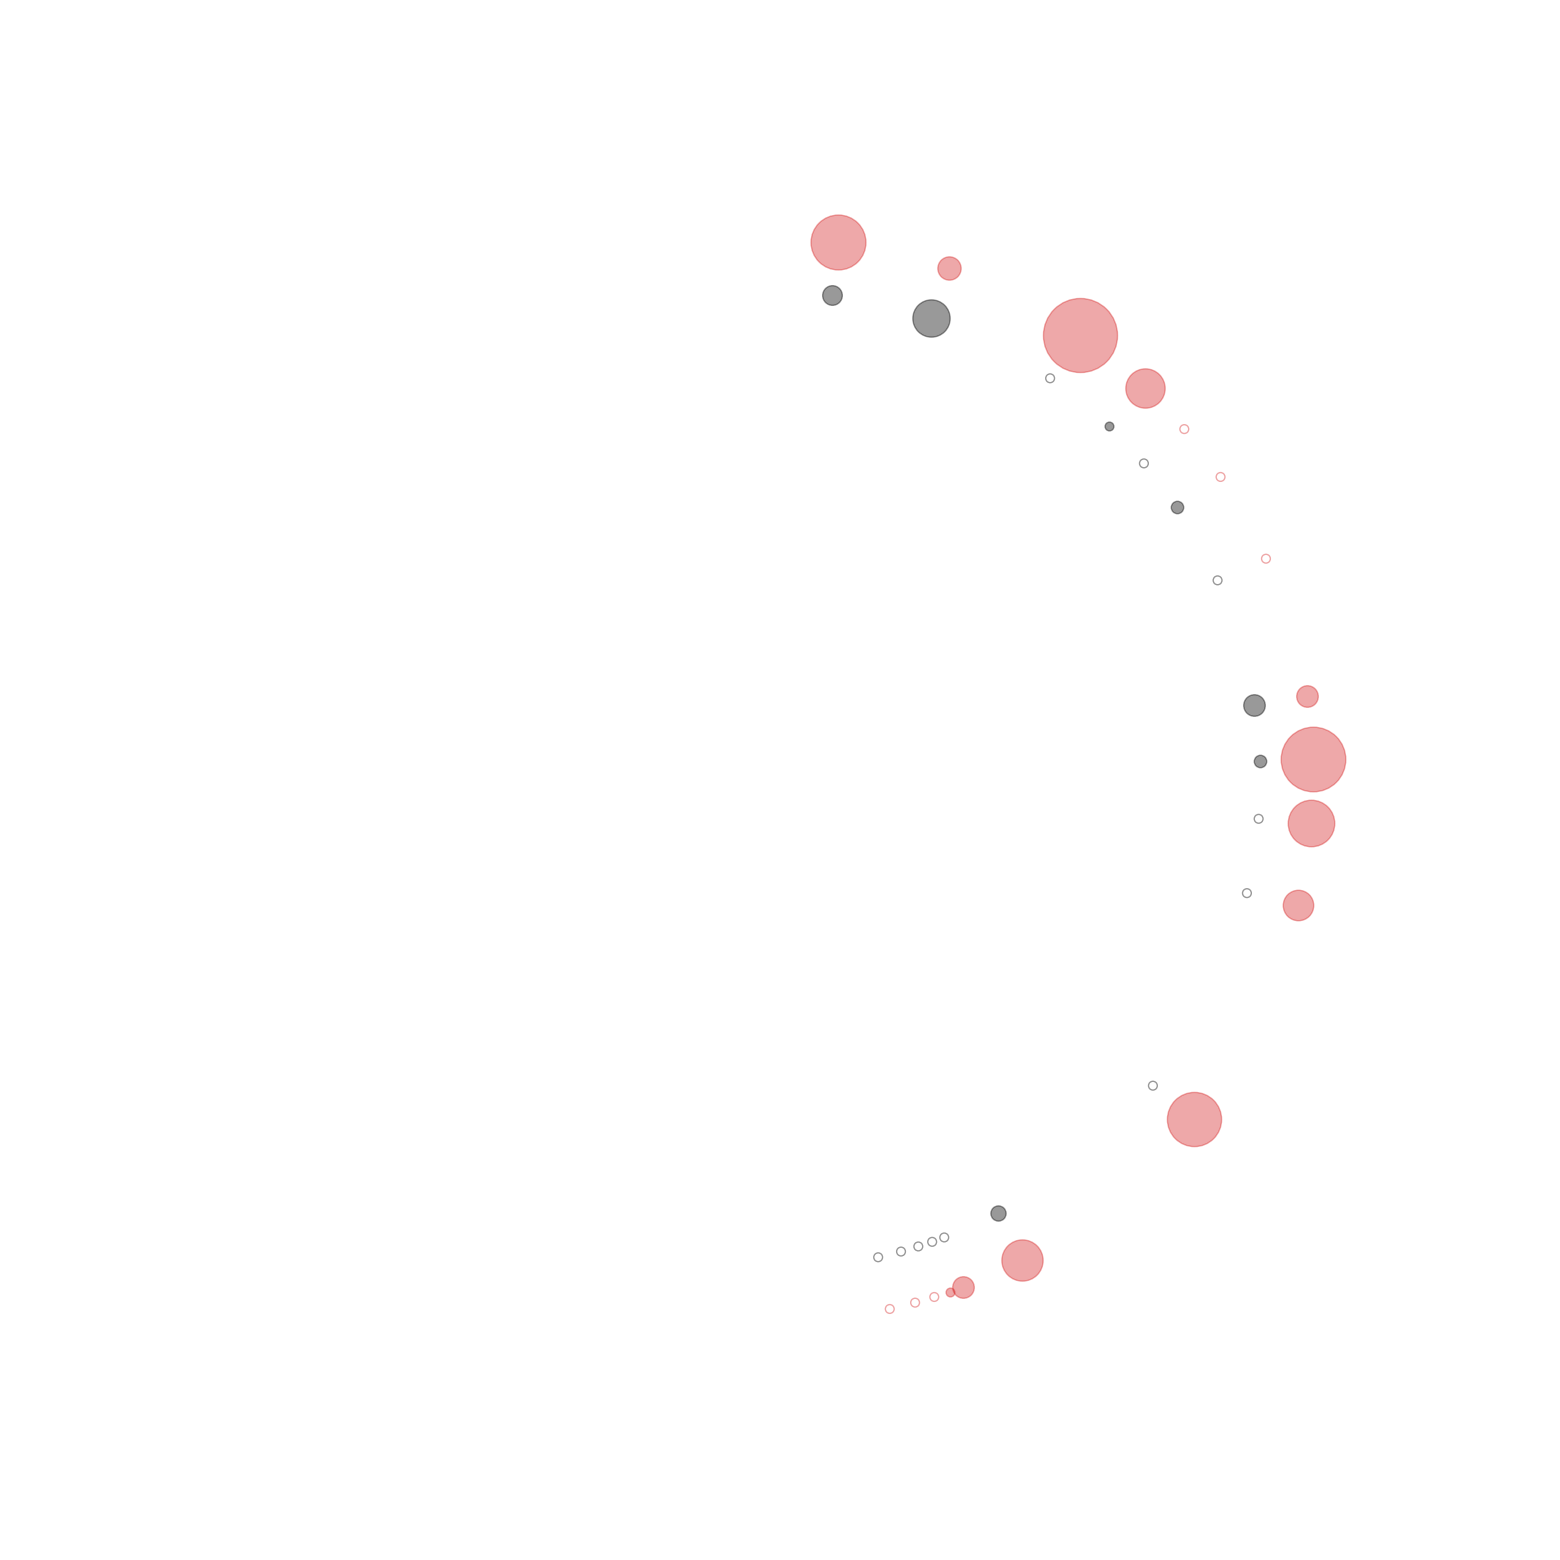

In [65]:
body_x = male_wing_viz[0]['x']
body_y = male_wing_viz[0]['y']
# print('Body original: ', body_x, body_y)
# center_x = 1720/2
# center_y = 1720/2
# print('Center:', center_x, center_y)
coordinates_black = dict()
coordinates_red = dict()
for asct in male_wing_viz:
    if asct['name'] in male_nodes[male_nodes['id_old']==1].name.values:
        # male_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates_red[asct['name']] = (round(body_x-10 + 13.3*(asct['x']-body_x),2), round(body_y + 13.3*(asct['y']-body_y), 2))
        coordinates_black[asct['name']] = (round(body_x-10 + 12*(asct['x']-body_x),2), round(body_y + 12*(asct['y']-body_y), 2))

mapping = {'Respiratory System': 'lung', 'heart': 'heart', 'brain': 'brain', 'eye': 'eye', 'skin': 'skin', 'thoracic thymus': 'thymus', 'lymph node': 'lymph node', 
           'spleen': 'spleen', 'liver': 'liver', 'Pancreas': 'pancreas', 'Small Intestine': 'small intestine', 'large intestine': 'large intestine', 'kidney': 'kidney', 
           'urinary bladder': 'urinary bladder', 'ureter': 'ureter', 'prostate gland': 'prostate gland', 'ovary': 'ovary', 'Fallopian tube':'fallopian_tube', 
           'Uterus': 'uterus', 'Placenta': 'placenta', 'knee': 'knee', 'Bone marrow': 'bone marrow'}

plt.figure(frameon=False, figsize=(20,20))
plt.axes().set_aspect('equal')
plt.axis('off')
plt.xlim(0,1720)
plt.ylim(-1720,0)
for organ in coordinates_black.keys():
    size_scale = 40
    if mapping[organ] in match_vess.keys():
        red_diam = nomatch_vess[mapping[organ]]
        if red_diam:
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=red_diam*size_scale, c='tab:red', alpha=0.4)            
        else: 
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4) 
            
        black_diam = match_vess[mapping[organ]]
        if black_diam:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=black_diam*size_scale, c='black', alpha=0.4)
        else:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
        
    else:
        plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4)
        plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
    
plt.savefig(f'viz_v13/male_bubbles_v13.svg', bbox_inches='tight', pad_inches=0)
   
plt.show()

In [66]:
with open('viz_v13/female_wing_viz_v13.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [67]:
female_wing_viz = viz['data'][0]['values']

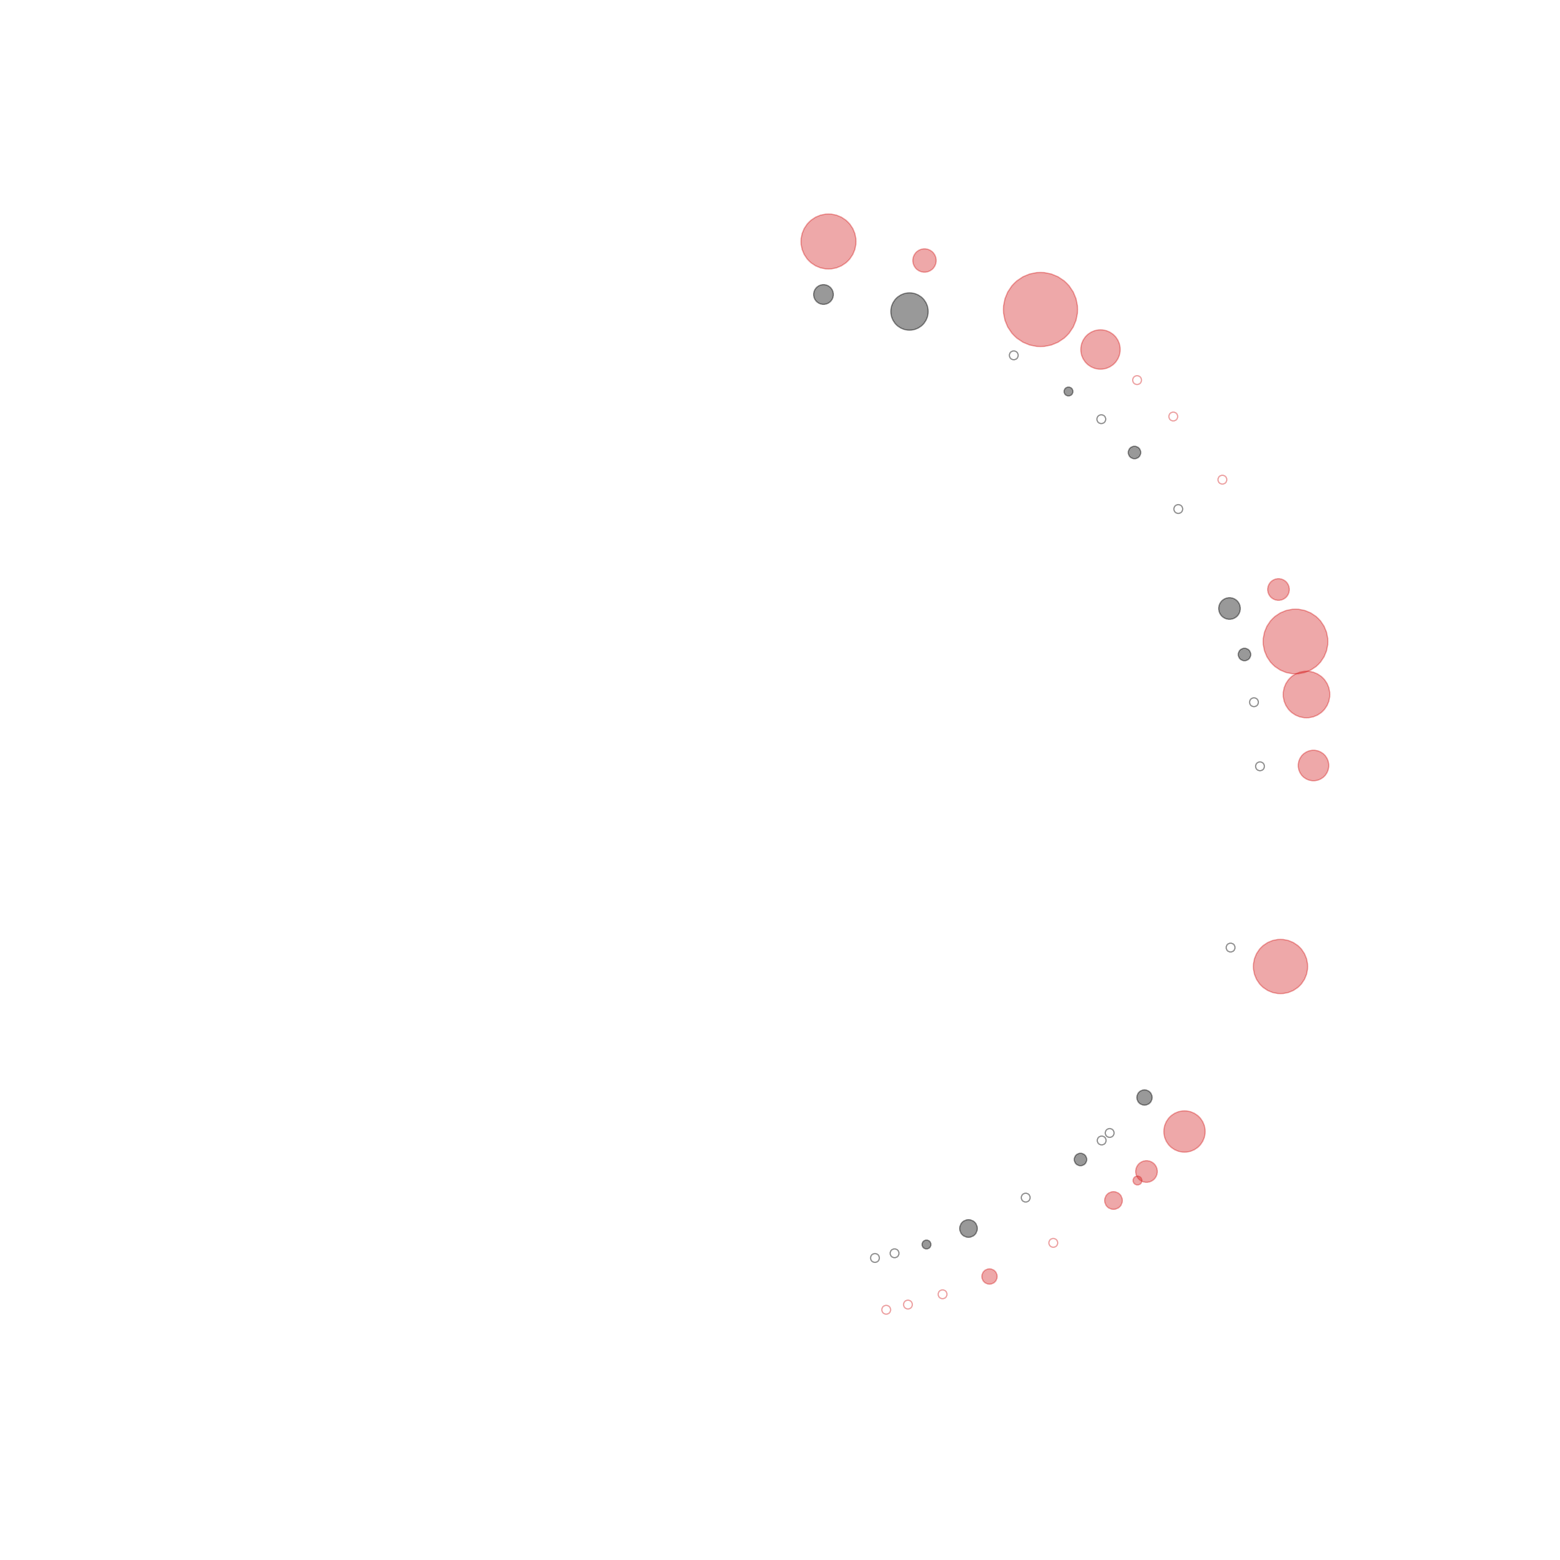

In [68]:
body_x = female_wing_viz[0]['x']
body_y = female_wing_viz[0]['y']
# print('Body original: ', body_x, body_y)
# center_x = 1720/2
# center_y = 1720/2
# print('Center:', center_x, center_y)
coordinates_black = dict()
coordinates_red = dict()
for asct in female_wing_viz:
    if asct['name'] in fem_nodes[fem_nodes['id_old']==1].name.values:
        # male_rots_for_organs[asct['name']] = -round(np.arctan((asct['x']-body_x)/(body_y-asct['y']))*180/np.pi, 3)
        coordinates_red[asct['name']] = (round(body_x-10 + 13.3*(asct['x']-body_x),2), round(body_y + 13.3*(asct['y']-body_y), 2))
        coordinates_black[asct['name']] = (round(body_x-10 + 12*(asct['x']-body_x),2), round(body_y + 12*(asct['y']-body_y), 2))

mapping = {'Respiratory System': 'lung', 'heart': 'heart', 'brain': 'brain', 'eye': 'eye', 'skin': 'skin', 'thoracic thymus': 'thymus', 'lymph node': 'lymph node', 
           'spleen': 'spleen', 'liver': 'liver', 'Pancreas': 'pancreas', 'Small Intestine': 'small intestine', 'large intestine': 'large intestine', 'kidney': 'kidney', 
           'urinary bladder': 'urinary bladder', 'ureter': 'ureter', 'prostate gland': 'prostate gland', 'ovary': 'ovary', 'Fallopian tube':'fallopian_tube', 
           'Uterus': 'uterus', 'Placenta': 'placenta', 'knee': 'knee', 'Bone marrow': 'bone marrow'}

plt.figure(frameon=False, figsize=(20,20))
plt.axes().set_aspect('equal')
plt.axis('off')
plt.xlim(0,1720)
plt.ylim(-1720,0)
for organ in coordinates_black.keys():
    size_scale = 40
    if mapping[organ] in match_vess.keys():
        red_diam = nomatch_vess[mapping[organ]]
        if red_diam:
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=red_diam*size_scale, c='tab:red', alpha=0.4)            
        else: 
            plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4) 
            
        black_diam = match_vess[mapping[organ]]
        if black_diam:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=black_diam*size_scale, c='black', alpha=0.4)
        else:
            plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
        
    else:
        plt.scatter([coordinates_red[organ][0]], [-coordinates_red[organ][1]], s=1*size_scale, facecolors='none', edgecolors='tab:red', alpha=0.4)
        plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=1*size_scale,  facecolors='none', edgecolors='black', alpha=0.4)
    
plt.savefig(f'viz_v13/female_bubbles_v13.svg', bbox_inches='tight', pad_inches=0)
   
plt.show()

In [216]:
body_y

860

### Size legend

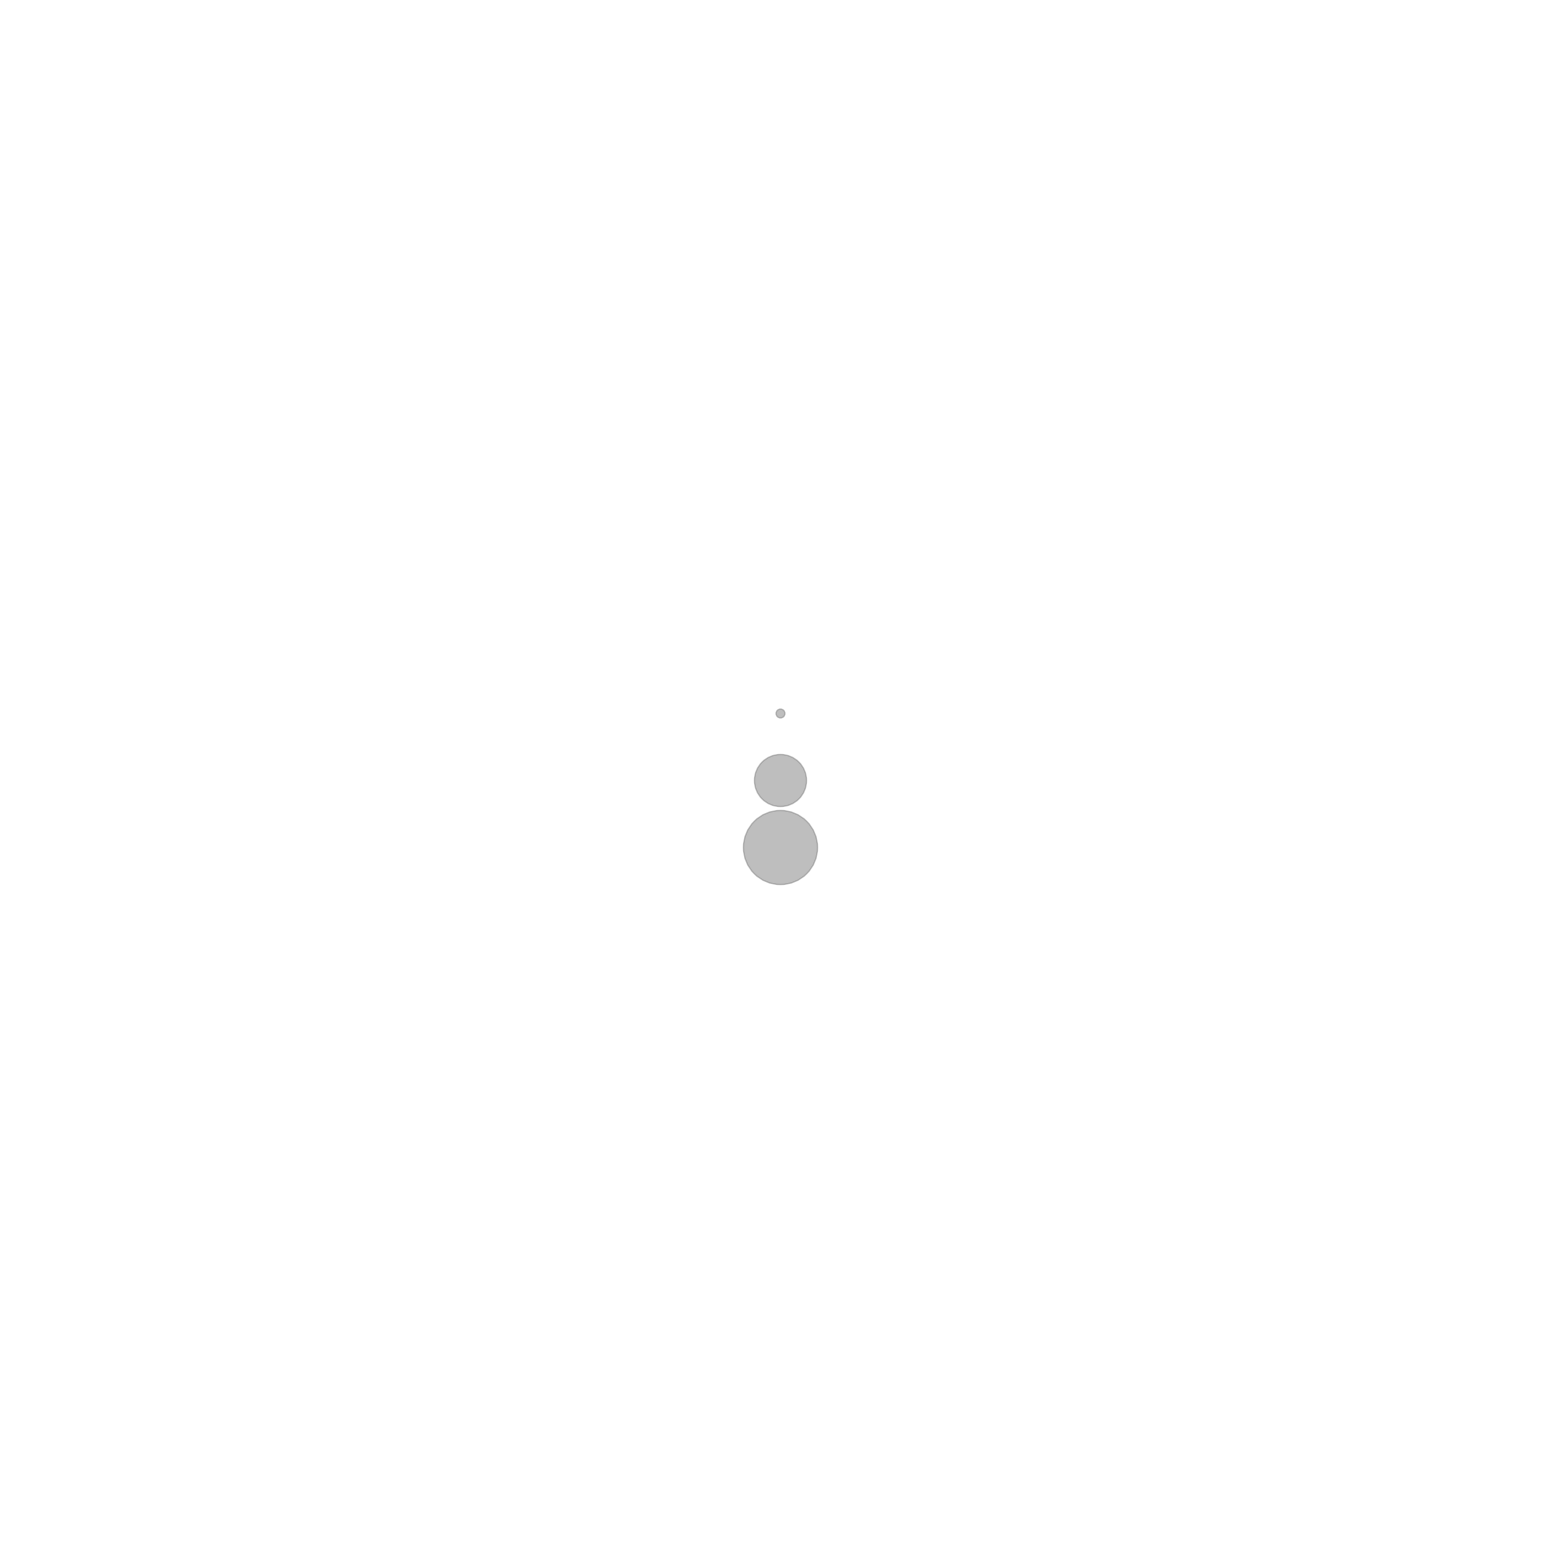

In [79]:
body_x = female_wing_viz[0]['x']
body_y = female_wing_viz[0]['y']
# print('Body original: ', body_x, body_y)
# center_x = 1720/2
# center_y = 1720/2
# print('Center:', center_x, center_y)
# sizes_black = {'one': 1, 'twntyfour': 24, 'fortyeight': 48, 'seventyone': 71}
# coordinates_black = {'one': (body_x, body_y-200), 'twntyfour': (body_x, body_y-100), 'fortyeight': (body_x, body_y), 'seventyone': (body_x, body_y+100)}
sizes_black = {'one': 1, '35': 35, 'seventyone': 71}
coordinates_black = {'one': (body_x, body_y-75), '35': (body_x, body_y), 'seventyone': (body_x, body_y+75)}

plt.figure(frameon=False, figsize=(20,20))
plt.axes().set_aspect('equal')
plt.axis('off')
plt.xlim(0,1720)
plt.ylim(-1720,0)
for organ in coordinates_black.keys():
    size_scale = 40

    plt.scatter([coordinates_black[organ][0]], [-coordinates_black[organ][1]], s=sizes_black[organ]*size_scale,alpha=0.5, c='tab:grey',)# facecolors='none', edgecolors='tab:grey')
        
    
plt.savefig(f'viz_v13/bubblesizelegend.svg', bbox_inches='tight', pad_inches=0)
   
plt.show()

# Vascular network 

In [86]:
matching_nodes = vasc_data[(vasc_data['is_in_organ_table']==1)&(vasc_data.BodyPart!='testis')]

In [88]:
matching_nodes.to_excel('matching_nodes_1.4.xlsx')

In [76]:
vasc_edges = vasc_data[['BranchesFrom', 'Vessel', 'VesselType']].copy()

In [77]:
# vasc_edges = pd.read_excel('./Blood_Vasculature_v1.3_EXTENDED.xlsx', sheet_name='Vessel')[['BranchesFrom', 'Vessel', 'VesselType']]
vasc_edges

,BranchesFrom,Vessel,VesselType
0,left atrium,left atrium,heart chamber
1,left atrium,left inferior pulmonary vein,vein
2,left atrium,left superior pulmonary vein,vein
3,left atrium,pulmonary vein,vein
4,pulmonary vein,segmental pulmonary vein,vein
...,...,...,...
1025,right interlobar pulmonary artery,posterior segmental artery of right lung,artery
1026,right interlobar pulmonary artery,superior segmental artery of right lung,artery
1027,right pulmonary artery,truncus anterior of right pulmonary artery,artery
1028,truncus anterior of right pulmonary artery,anterior segmental artery of right lung,artery


In [78]:
matching_nodes

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels
0,left atrium,left atrium,UBERON:0002079,heart chamber,heart chamber,UBERON:0004151,left atrium,left atrium;left cardiac atrium;UBERON:0002079,1,0,1
1,left atrium,left inferior pulmonary vein,fma49913,vein,lung,UBERON:0002048,left atrium;left inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
2,left atrium,left superior pulmonary vein,fma49916,vein,lung,UBERON:0002048,left atrium;left superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
7,left atrium,right inferior pulmonary vein,fma49911,vein,lung,UBERON:0002048,left atrium;right inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
8,left atrium,right superior pulmonary vein,fma49914,vein,lung,UBERON:0002048,left atrium;right superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
9,left ventricle,left ventricle,UBERON:0002084,heart chamber,heart chamber,UBERON:0004151,left ventricle,left ventricle;heart left ventricle;UBERON:000...,1,0,1
150,short posterior ciliary artery,capillary layer of choroid,UBERON:0005336,capillary,eye,UBERON:0000970,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1
191,celiac artery,splenic artery,UBERON:0001194,artery,spleen,UBERON:0002106,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1
200,segmental branch of lobar artery of spleen,spleen trabecular artery,UBERON:0010399,artery,spleen,UBERON:0002106,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1
201,spleen trabecular artery,spleen central arteriole,UBERON:0010401,arteriole,spleen,UBERON:0002106,left ventricle;aorta;ascending aorta;aortic ar...,left ventricle;heart left ventricle;UBERON:000...,1,0,1


In [79]:
vasc_edges = vasc_edges.rename(columns={'BranchesFrom':'source', 'Vessel': 'target'})
# vasc_edges.to_excel('vasc_edgelist.xlsx')

In [80]:
#Removal of the self-loops
vasc_edges = vasc_edges[vasc_edges.source!=vasc_edges.target]

In [81]:
vasc_graph = nx.from_pandas_edgelist(vasc_edges)

In [82]:
layout_pos_full = nx.drawing.nx_agraph.graphviz_layout(vasc_graph)

C:\Users\admin\anaconda3\Lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: 
(process:11736): GLib-GIO-WARNING **: 16:44:49.763: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.7.10.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:11736): GLib-GIO-WARNING **: 16:44:49.778: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2307.48.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


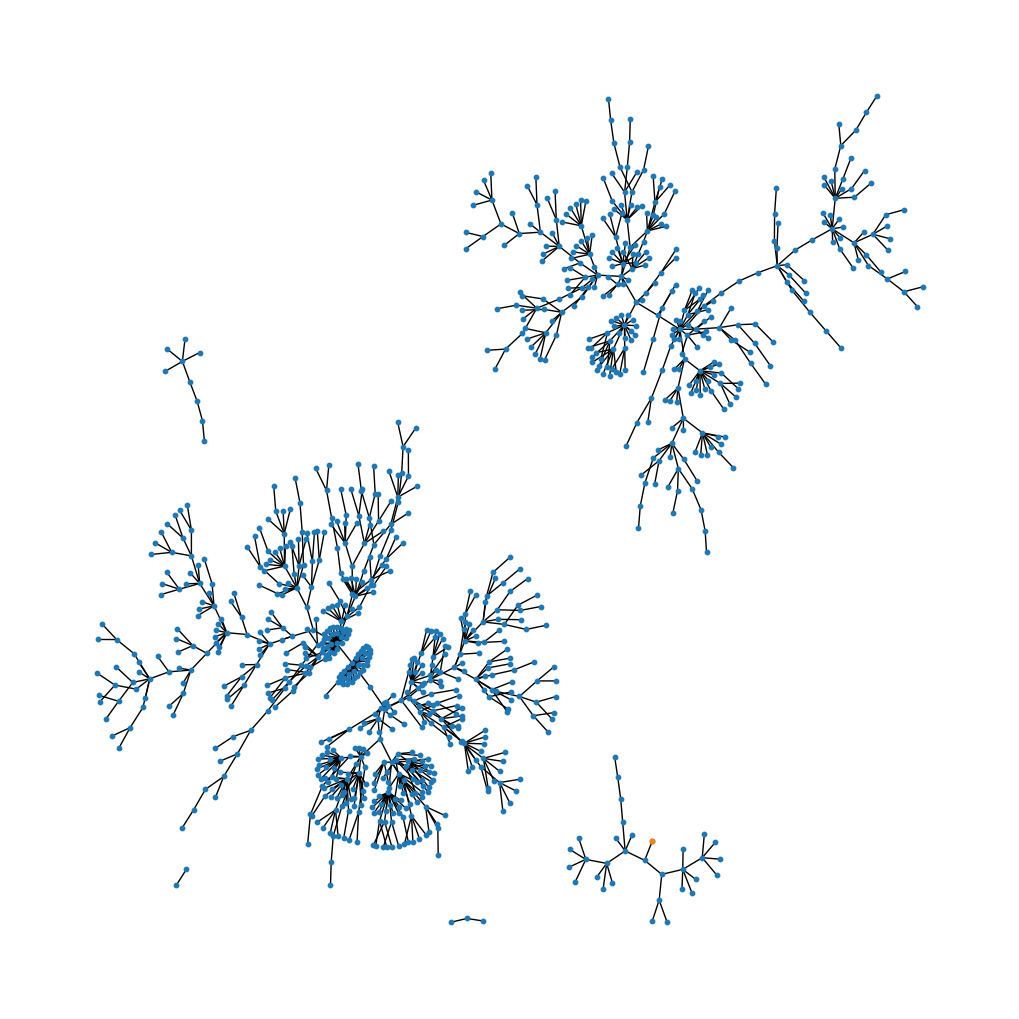

In [83]:
plt.figure(figsize=(10,10))
nx.draw(vasc_graph, pos=layout_pos_full, node_size=10)
nx.draw_networkx_nodes(vasc_graph, layout_pos_full, nodelist=['right ventricle'], node_size=10, node_color='tab:orange')
plt.show()

### Construction of the pruned graph

The graph has to be pruned at the matching nodes

We start with the layer of matching nodes, and then in each iteration, we get the parent nodes (vessels), i.e. we are moving towards the core of the network in layers. 

In [84]:
layer = vasc_edges[vasc_edges.target.isin(matching_nodes.Vessel)]
layers = [layer]
indices = list(layer.index)
while len(layer):
    layer = vasc_edges[(vasc_edges.target.isin(layer.source)) & (~vasc_edges.index.isin(indices))]
    layers += [layer]
    indices += list(layer.index)

In [85]:
pruned_vasc_edges = vasc_edges[vasc_edges.index.isin(indices)]

In [86]:
len(pruned_vasc_edges)

78

Nodes of the pruned network:

In [87]:
vasc_data[vasc_data['Vessel'].isin(set(pruned_vasc_edges[['source', 'target']].values.flatten()))]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels
0,left atrium,left atrium,UBERON:0002079,heart chamber,heart chamber,UBERON:0004151,left atrium,left atrium;left cardiac atrium;UBERON:0002079,1,0,1
1,left atrium,left inferior pulmonary vein,fma49913,vein,lung,UBERON:0002048,left atrium;left inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
2,left atrium,left superior pulmonary vein,fma49916,vein,lung,UBERON:0002048,left atrium;left superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
7,left atrium,right inferior pulmonary vein,fma49911,vein,lung,UBERON:0002048,left atrium;right inferior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
8,left atrium,right superior pulmonary vein,fma49914,vein,lung,UBERON:0002048,left atrium;right superior pulmonary vein,left atrium;left cardiac atrium;UBERON:0002079...,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
731,hepatic portal vein,splenic vein,UBERON:0003713,vein,spleen,UBERON:0002106,right atrium;inferior vena cava;left hepatic v...,right atrium;right cardiac atrium;UBERON:00020...,1,0,1
746,splenic vein,spleen trabecular vein,UBERON:0010400,vein,spleen,UBERON:0002106,right atrium;inferior vena cava;left hepatic v...,right atrium;right cardiac atrium;UBERON:00020...,1,0,1
818,right atrium,superior vena cava,UBERON:0001585,vein,thoracic cavity,UBERON:0002224,right atrium;superior vena cava,right atrium;right cardiac atrium;UBERON:00020...,0,1,1
992,superior vena cava,left brachiocephalic vein,fma4761,vein,thoracic cavity,UBERON:0002224,right atrium;superior vena cava;left brachioce...,right atrium;right cardiac atrium;UBERON:00020...,0,1,1


In [88]:
vasc_data[vasc_data['Vessel'].isin(set(pruned_vasc_edges[['source', 'target']].values.flatten()))][['BodyPart', 'Vessel', 'ASID', 'VesselType']].to_excel('./viz_v14/nodes_of_vascular_network_v14.xlsx')

In [89]:
pruned_vasc_edges.to_excel('viz_v14/vasc_edgelist_v14.xlsx')
vasc_edges.to_excel('viz_v14/vasc_edgelist_all_v14.xlsx')

In [90]:
pruned_vasc_graph = nx.from_pandas_edgelist(pruned_vasc_edges)

In [91]:
len(pruned_vasc_graph)

81

In [92]:
pruned_vasc_graph = nx.induced_subgraph(vasc_graph, set(pruned_vasc_graph.nodes).union(set(matching_nodes.Vessel.values)))

In [93]:
len(pruned_vasc_graph)

82

Note that the network is not connected, hence we have to add manually the 'heart' node and connect it to the components

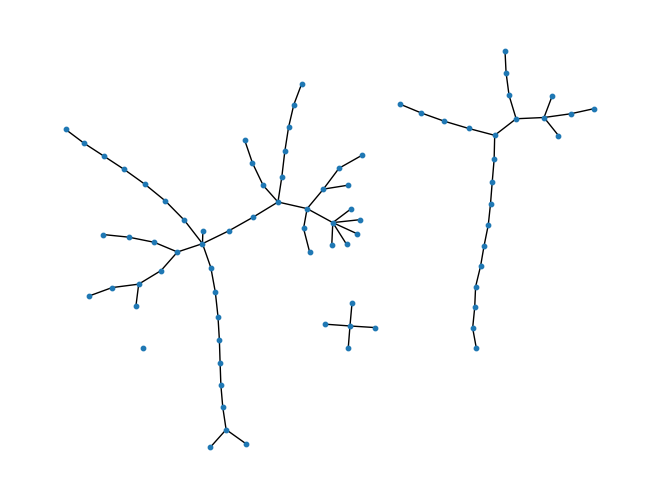

In [94]:
layout_pos = nx.drawing.nx_agraph.graphviz_layout(pruned_vasc_graph)
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)

### Get the coordinates from the Vega visualization 

In [95]:
with open('viz_v14/female_wing_viz_v14.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [96]:
female_viz = viz['data'][0]['values']

Merge of heart & heart chamber, thyroid gland & lung and rename pelvis to placenta

In [97]:
matching_nodes['BodyPart'].value_counts()

BodyPart
heart            14
spleen            6
heart chamber     4
lung              4
uterus            4
kidney            4
thymus            2
liver             2
eye               1
pelvis            1
ovary             1
Name: count, dtype: int64

In [98]:
organ_mapping = {'eye': 'eye', 'heart': 'heart', 
                 'heart chamber': 'heart', # heart chamber -> heart
                 'kidney': 'kidney',  'liver': 'liver', 'lung': 'lung', 'ovary': 'ovary', 
                 'pelvis': 'placenta_full_term', #pelvis -> placenta
                 'spleen': 'spleen', 'thymus': 'thymus', 
                 'thyroid gland': 'lung', #thyroid gland -> lung
                 'uterus': 'uterus'}

In [99]:
matching_nodes['organ'] = matching_nodes['BodyPart'].apply(lambda x: organ_mapping[x])

C:\Users\admin\AppData\Local\Temp\ipykernel_17172\3730747861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_nodes['organ'] = matching_nodes['BodyPart'].apply(lambda x: organ_mapping[x])


Get the coordinates for the vessels

## Full graph

In [100]:
matching_nodes['ASID'].apply(transform_id).values

array(['uberon0002079', 'fma49913', 'fma49916', 'fma49911', 'fma49914',
       'uberon0002084', 'uberon0005336', 'uberon0001194', 'uberon0010399',
       'uberon0010401', 'uberon0013132', 'fma70195', 'uberon0001310',
       'uberon0002493', 'uberon0015173', 'uberon0001190', 'uberon0004639',
       'uberon0004640', 'uberon0005272', 'uberon0004726', 'uberon0018243',
       'fma3862', 'fma3860', 'uberon0035422', 'uberon0001625', 'fma3851',
       'fma15736', 'fma3840', 'fma3818', 'fma3823', 'uberon0002078',
       'uberon0005438', 'uberon0006958', 'fma4708', 'uberon0009687',
       'uberon0035374', 'uberon0008889', 'uberon0006841', 'uberon0001281',
       'uberon0003713', 'uberon0010400', 'uberon0001591', 'uberon0002080'],
      dtype=object)

In [101]:
def get_coordinates_4_vessels(visualization, graph=pruned_vasc_graph):
    name = []
    name_in_vasc = []
    coords=[]
    organs = []
    for node in visualization:
        if transform_id(node['ontology_id']) in matching_nodes['ASID'].apply(transform_id).values: #if the node is in the vascular data 
            # if node['organ']==matching_nodes[matching_nodes['ASID'].apply(transform_id)==transform_id(node['ontology_id'])]['organ'].values[0]: # and if the organs match
            name += [node['name']]
            name_in_vasc += [matching_nodes[matching_nodes['ASID'].apply(transform_id)==transform_id(node['ontology_id'])]['Vessel'].values[0]]
            coords += [np.array([node['x'], -node['y']])]
            organs += [node['organ']]

    for node in graph:
        if node not in name_in_vasc:
            name += [node]
            name_in_vasc += [node]
            coords += [np.nan]
            organs += [np.nan]

    art_data = pd.DataFrame.from_dict({'name': name, 'name_in_vasc': name_in_vasc,
                                       'organ': organs, 'coords': coords})
    
    art_data = art_data.drop_duplicates(subset=['name_in_vasc', 'organ']).reset_index(drop=True) 
    
    art_data = art_data[art_data.name_in_vasc.isin(graph.nodes())]
    
    return art_data

In [102]:
matching_nodes.to_excel('matching_nodes_v14.xlsx')

In [103]:
coords = get_coordinates_4_vessels(female_viz)

In [104]:
coords

,name,name_in_vasc,organ,coords
0,right atrium,right atrium,heart,"[918.5926032878547, -740.5162174369534]"
1,sinoatrial nodal artery,sinoatrial nodal artery,heart,"[944.7243201154679, -679.2568359352983]"
2,left circumflex artery,left circumflex artery,heart,"[952.3550842361159, -683.0343530769662]"
3,atrioventicular nodal artery,atrioventicular nodal artery,heart,"[953.1702112406256, -683.4621470830543]"
4,coronary sinus,coronary sinus,heart,"[953.9833567277409, -683.8936956456864]"
...,...,...,...,...
77,left coronary artery,left coronary artery,NaN,NaN
78,common iliac vein,common iliac vein,NaN,NaN
79,anterior division of internal iliac artery,anterior division of internal iliac artery,NaN,NaN
80,internal thoracic artery,internal thoracic artery,NaN,NaN


In [105]:
len(matching_nodes)

43

In [106]:
len(coords.dropna())

43

In [107]:
nodes_wo_coords = [node for node in coords[coords['coords'].isna()]['name_in_vasc'].values if node in matching_nodes['Vessel'].values ]
nodes_wo_coords

[]

In [108]:
matching_nodes[matching_nodes['Vessel'].isin(nodes_wo_coords)]

,BranchesFrom,Vessel,ASID,VesselType,BodyPart,BodyPartID,PathFromHeart,PathFromHeartWithIDs,is_in_organ_table,not_in_organ_table,#vessels,organ


In [109]:
nodes[nodes['ontology_id'].apply(transform_id).isin(matching_nodes[matching_nodes['Vessel'].isin(nodes_wo_coords)]['ASID'].apply(transform_id).values)]

,id,id_old,name,type,organ,ontology_id,parent,color


In [110]:
relabel_mapping = coords['name_in_vasc'].to_dict()
relabel_mapping = {v: k for k, v in relabel_mapping.items()}

In [111]:
renamed_pruned_vasc = nx.relabel_nodes(pruned_vasc_graph, relabel_mapping)

In [112]:
pos = coords['coords'].dropna().to_dict()

In [113]:
pos2 = nx.spring_layout(renamed_pruned_vasc, pos=pos, fixed=list(pos.keys()), iterations=1000)

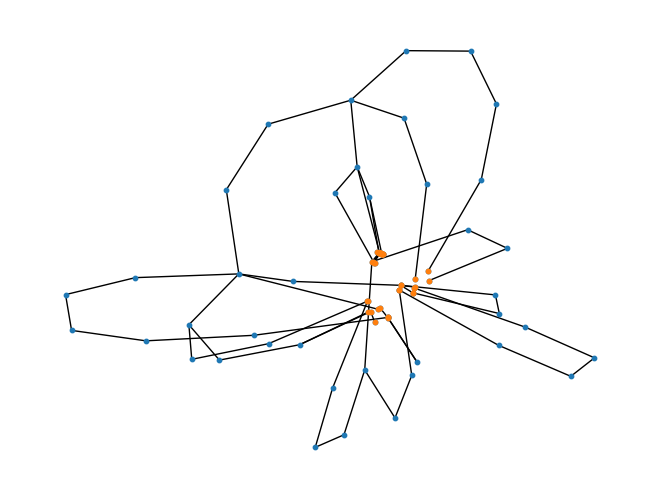

In [114]:
nx.draw(renamed_pruned_vasc, pos2, node_size=10)
nx.draw_networkx_nodes(renamed_pruned_vasc, pos2, nodelist=list(pos.keys()), node_color='tab:orange', node_size=10)
# plt.savefig('small_network.png', dpi=300)
plt.show()

In [115]:
connected_comps = [pruned_vasc_graph.subgraph(c).copy() for c in nx.connected_components(pruned_vasc_graph)]

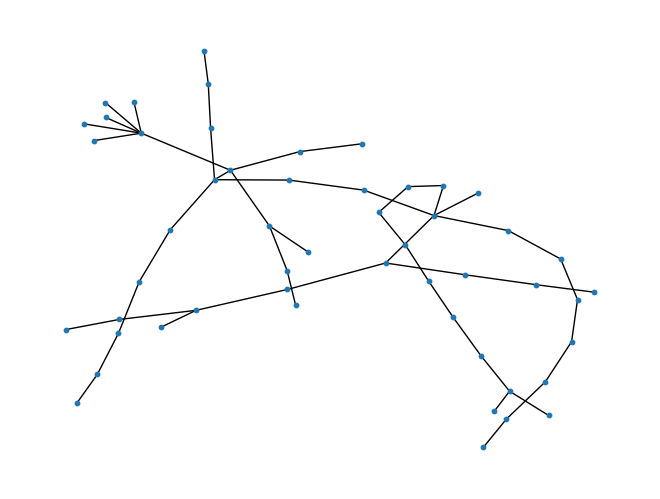

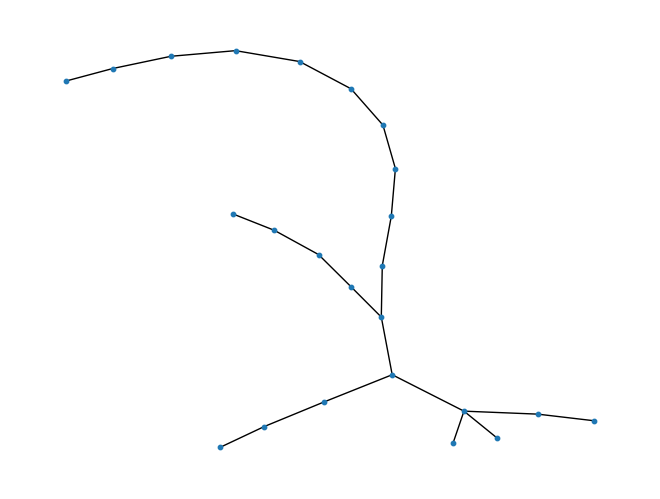

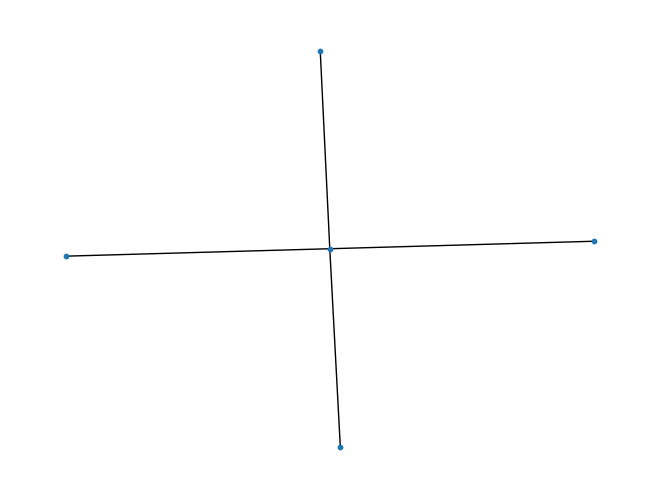

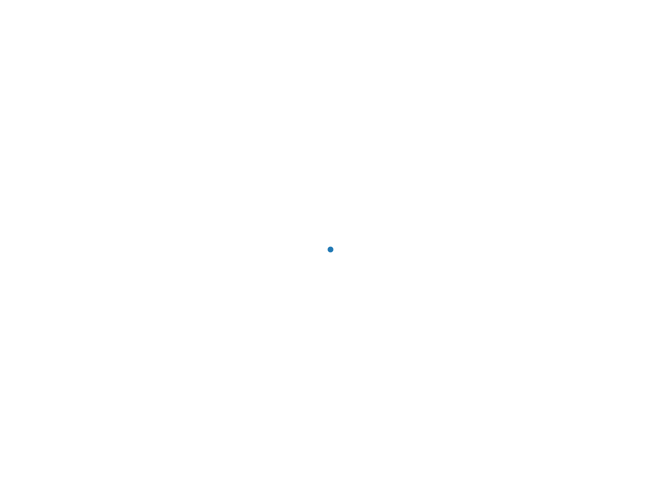

In [116]:
for comp in connected_comps:
    nx.draw(comp, node_size=10)
    plt.show()

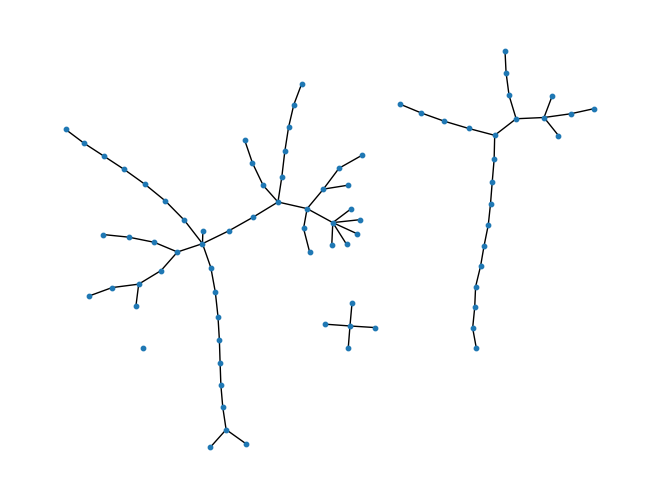

In [117]:
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)
plt.show()

In [118]:
leaves_of_pruned = [node for node in pruned_vasc_graph if nx.degree(pruned_vasc_graph, node)<=1]

In [119]:
len(leaves_of_pruned)

28

In [120]:
matching_not_leaf = [node for node in matching_nodes.Vessel.values if node not in leaves_of_pruned]

In [121]:
matching_leaf = [node for node in matching_nodes.Vessel.values if node in leaves_of_pruned]

In [122]:
len(matching_not_leaf)+len(matching_leaf)

43

In [123]:
len(matching_nodes)

43

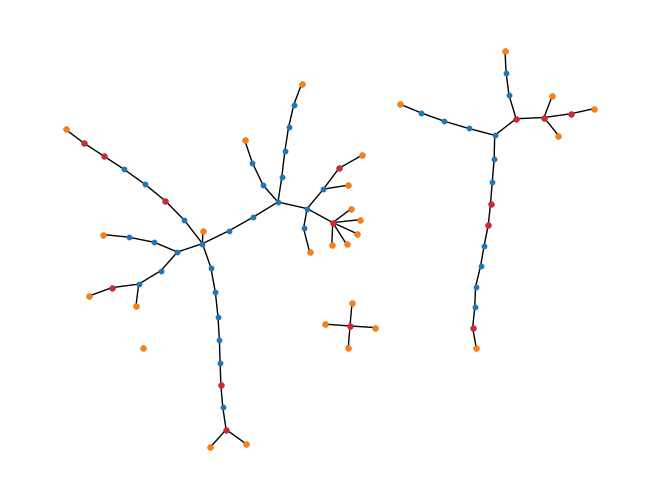

In [124]:
nx.draw(pruned_vasc_graph, pos=layout_pos, node_size=10)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=matching_not_leaf, 
                       node_color='tab:red', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos,
                       nodelist=matching_leaf, 
                       node_color='tab:orange', node_size=12)
plt.show()

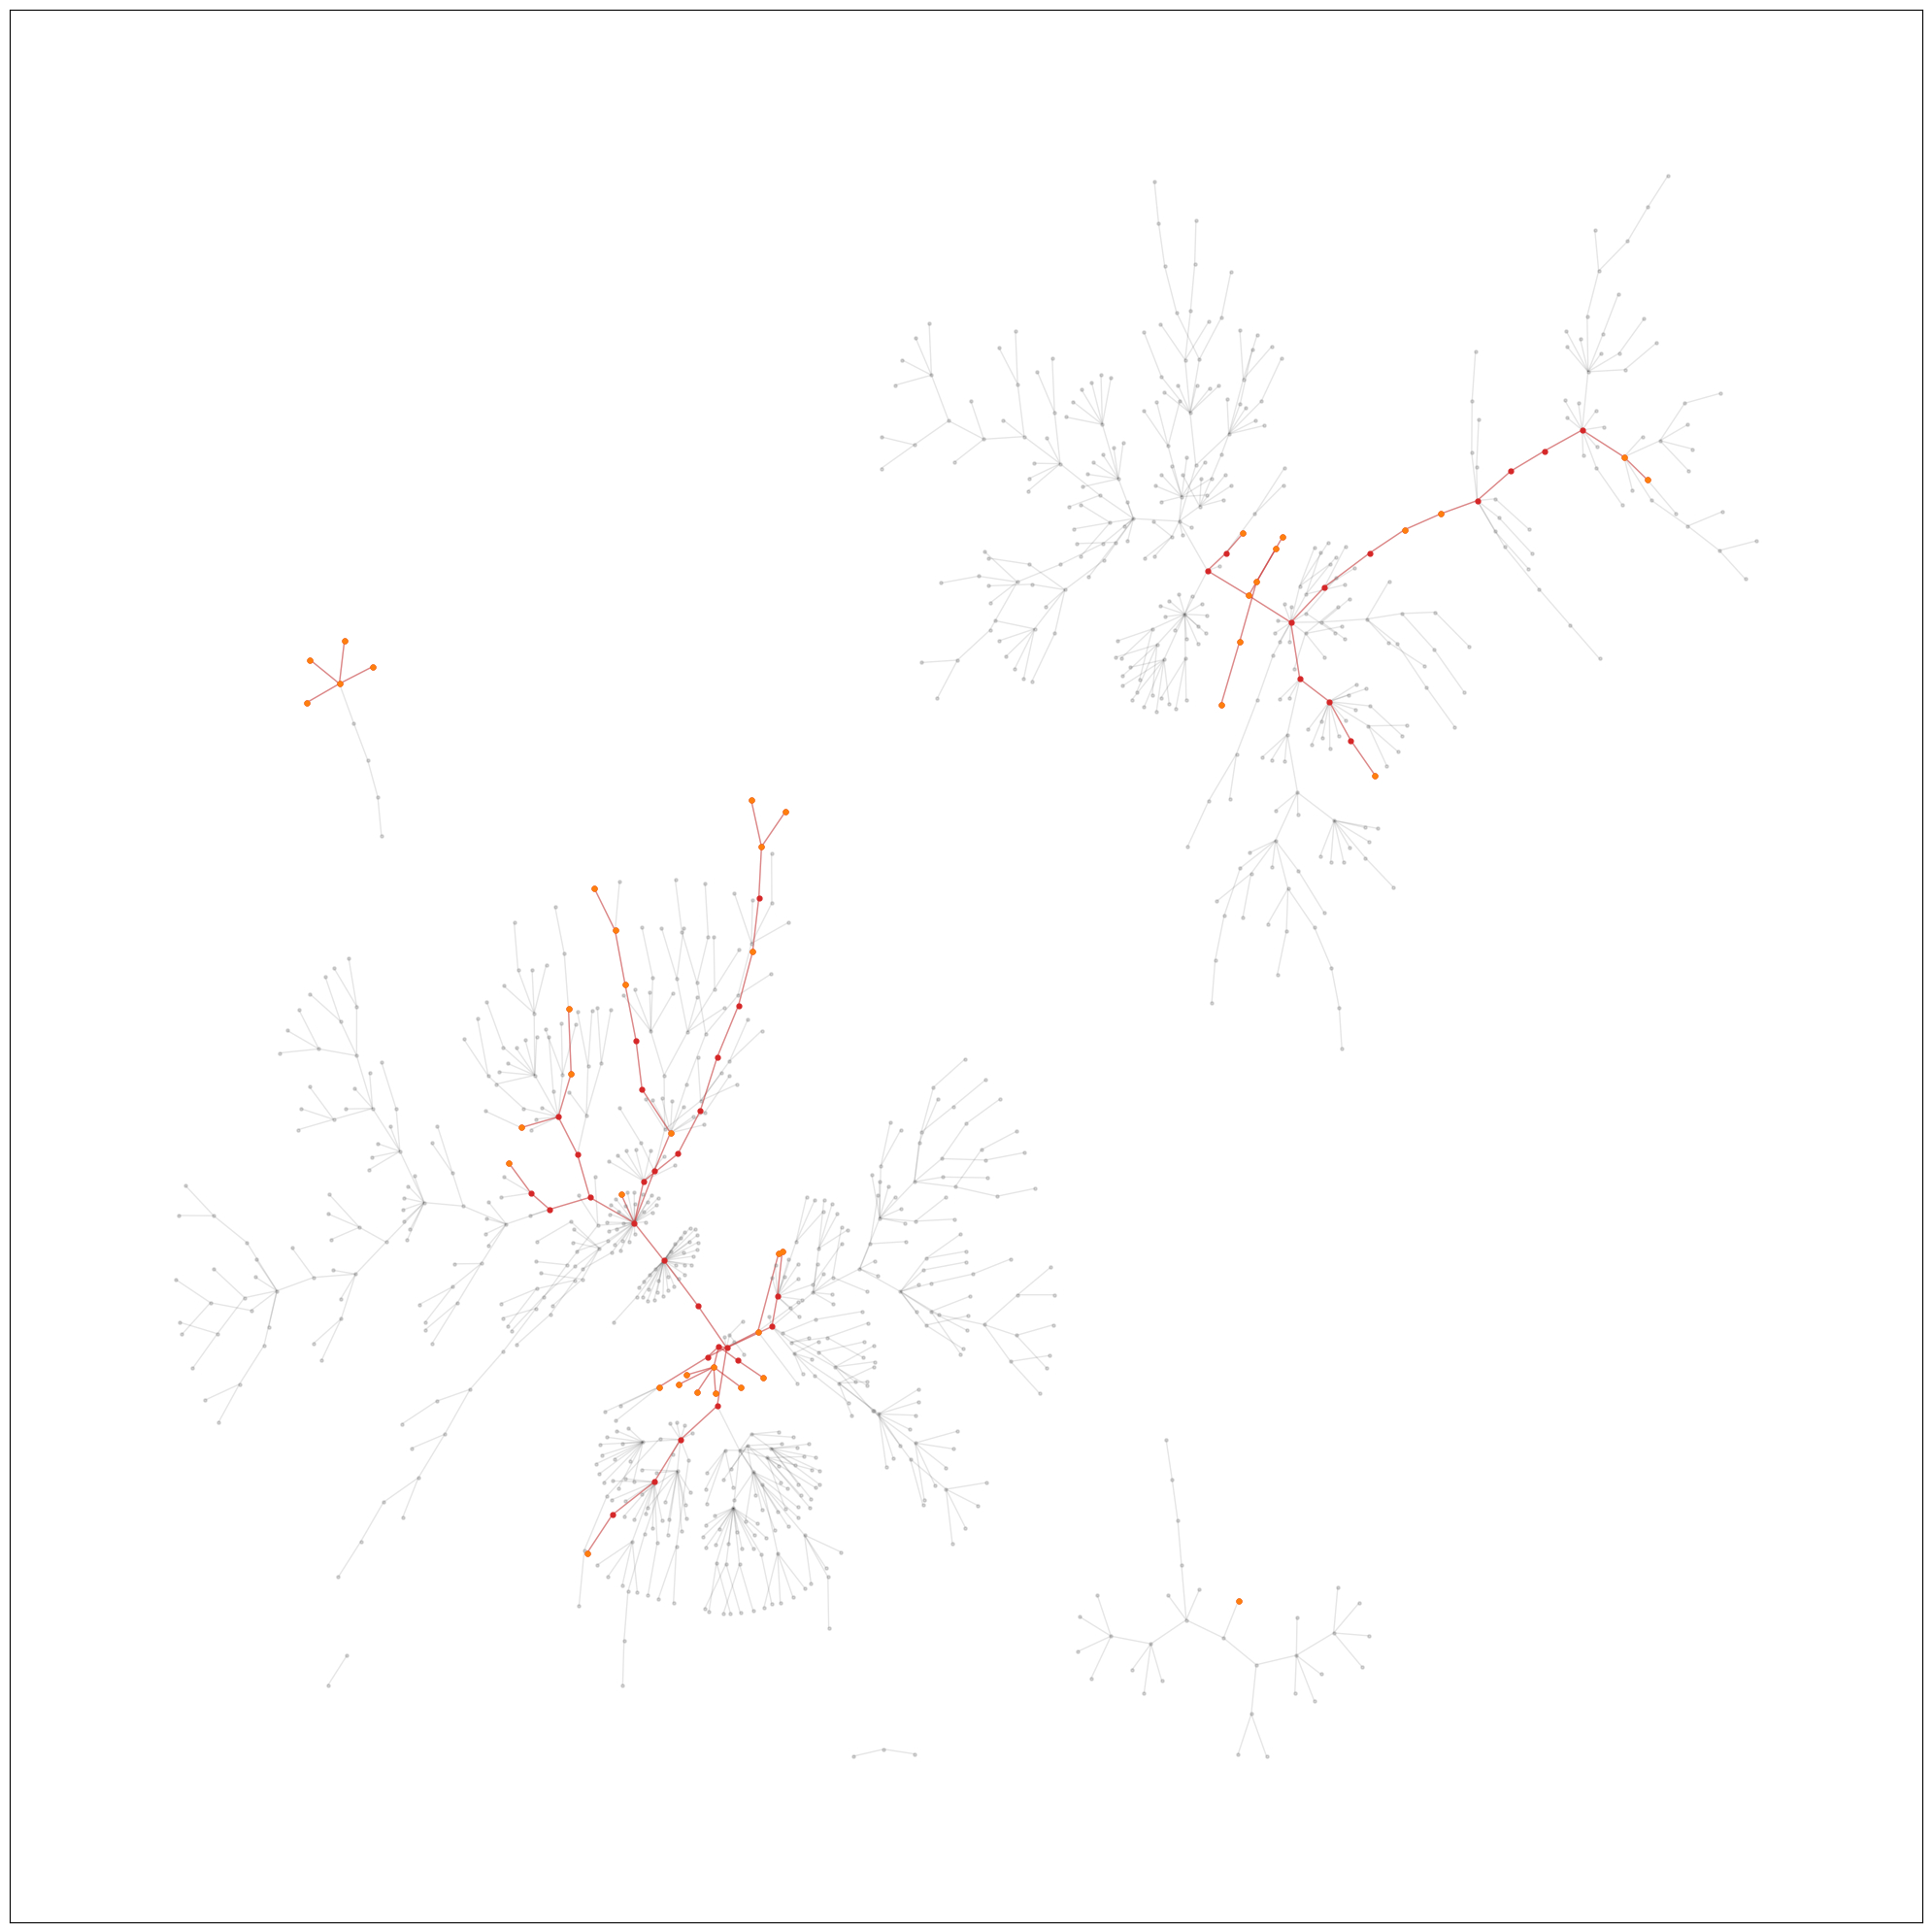

In [125]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(vasc_graph, pos=layout_pos_full, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_edges(vasc_graph, pos=layout_pos_full, alpha=0.1)
nx.draw_networkx_edges(pruned_vasc_graph, pos=layout_pos_full, alpha=0.5, edge_color='tab:red')
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=pruned_vasc_graph.nodes, 
                       node_color='tab:red', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=matching_not_leaf, 
                       node_color='tab:orange', node_size=12)
nx.draw_networkx_nodes(pruned_vasc_graph, layout_pos_full,
                       nodelist=matching_leaf, 
                       node_color='tab:orange', node_size=12)
plt.tight_layout()
plt.savefig('vascular_v14.png', dpi=300)
plt.show()

# Connect the components of the vascular network 

In [126]:
# Load json files 
json_data_asctb_blood = {}
for filename in listdir('./asct+b/v14/'):
    if '.json' in filename:
        # print(filename)
        with open(f'./asct+b/v14/{filename}', encoding='utf8') as json_file:
            data = json.load(json_file)

        json_data_asctb_blood[filename[:-5]] = data

In [127]:
json_data_asctb_blood.keys()

dict_keys(['blood', 'blood_vasculature', 'bone_marrow', 'brain', 'eye', 'fallopian_tube', 'heart', 'kidney', 'knee', 'large_intestine', 'liver', 'lung', 'lymph_nodes', 'lymph_vasculature', 'main_bronchus', 'muscular_system', 'ovary', 'pancreas', 'peripheral_nervous_system', 'placenta_full_term', 'prostate', 'skeleton', 'skin', 'small_intestine', 'spinal_cord', 'spleen', 'thymus', 'trachea', 'ureter', 'urinary_bladder', 'uterus'])

In [128]:
nodes, edges = combine_data(json_data_asctb_blood, remove_ctct=True, combine=False, blood=True)

blood is tree: True
_____________
blood_vasculature is tree: True
_____________
bone_marrow is tree: True
_____________
brain is tree: True
_____________
eye is tree: True
_____________
fallopian_tube is tree: True
_____________
heart is tree: True
_____________
kidney is tree: True
_____________
knee is tree: True
_____________
large_intestine is tree: True
_____________
liver is tree: True
_____________
lung is tree: True
_____________
lymph_nodes is tree: True
_____________
main_bronchus is tree: True
_____________
muscular_system is tree: True
_____________
ovary is tree: True
_____________
pancreas is tree: True
_____________
placenta_full_term is tree: True
_____________
prostate is tree: True
_____________
skeleton is tree: True
_____________
skin is tree: True
_____________
small_intestine is tree: True
_____________
spinal_cord is tree: True
_____________
spleen is tree: True
_____________
thymus is tree: True
_____________
trachea is tree: True
_____________
ureter is tree: T

In [129]:
blood_vasc_nodes = nodes['blood_vasculature']

In [130]:
blood_vasc_edges = edges['blood_vasculature']

In [131]:
blood_vasc_nodes

,id,id_old,name,type,organ,ontology_id
id,,,,,,
0,0,0,Body,AS,body,UBERON:0013702
1,1,1,blood vasculature,AS,blood_vasculature,UBERON:0004537
2,2,2,left atrium,AS,blood_vasculature,UBERON:0002079
3,3,3,left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
4,4,4,left superior pulmonary vein,AS,blood_vasculature,FMA:49916
...,...,...,...,...,...,...
4276,4276,1038,endothelial cell of arteriole,CT,blood_vasculature,CL:1000412
4277,4277,1038,endothelial cell of arteriole,CT,blood_vasculature,CL:1000412
4278,4278,1038,endothelial cell of arteriole,CT,blood_vasculature,CL:1000412


In [132]:
blood_vasc_graph = nx.from_pandas_edgelist(blood_vasc_edges)

In [133]:
blood_vasc_graph = nx.relabel_nodes(blood_vasc_graph, blood_vasc_nodes['name'].to_dict())

In [134]:
pos = nx.drawing.nx_pydot.graphviz_layout(G=blood_vasc_graph, root='blood vasculature')

C:\Users\admin\AppData\Local\Temp\ipykernel_17172\2861256661.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.drawing.nx_pydot.graphviz_layout(G=blood_vasc_graph, root='blood vasculature')


In [135]:
[node for node in pruned_vasc_graph if node not in blood_vasc_graph]

['hepatic portal vein']

In [136]:
subgraph = nx.induced_subgraph(blood_vasc_graph, list(pruned_vasc_graph.nodes)+['blood vasculature'])

In [137]:
pos = nx.drawing.nx_pydot.graphviz_layout(subgraph, root='blood vasculature')

C:\Users\admin\AppData\Local\Temp\ipykernel_17172\1543655099.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.drawing.nx_pydot.graphviz_layout(subgraph, root='blood vasculature')


In [138]:
pos_of_pruned = nx.spring_layout(pruned_vasc_graph, pos=pos, fixed=pos.keys(), iterations=1000, dim=2, k=0.01/np.sqrt(len(pruned_vasc_graph)))

In [139]:
connected_comps = [pruned_vasc_graph.subgraph(c).copy() for c in nx.connected_components(pruned_vasc_graph)]

In [140]:
new_edges = [edge for edge in subgraph.edges if edge not in pruned_vasc_graph.edges]

In [141]:
connected_comps[3].nodes

NodeView(('right ventricle',))

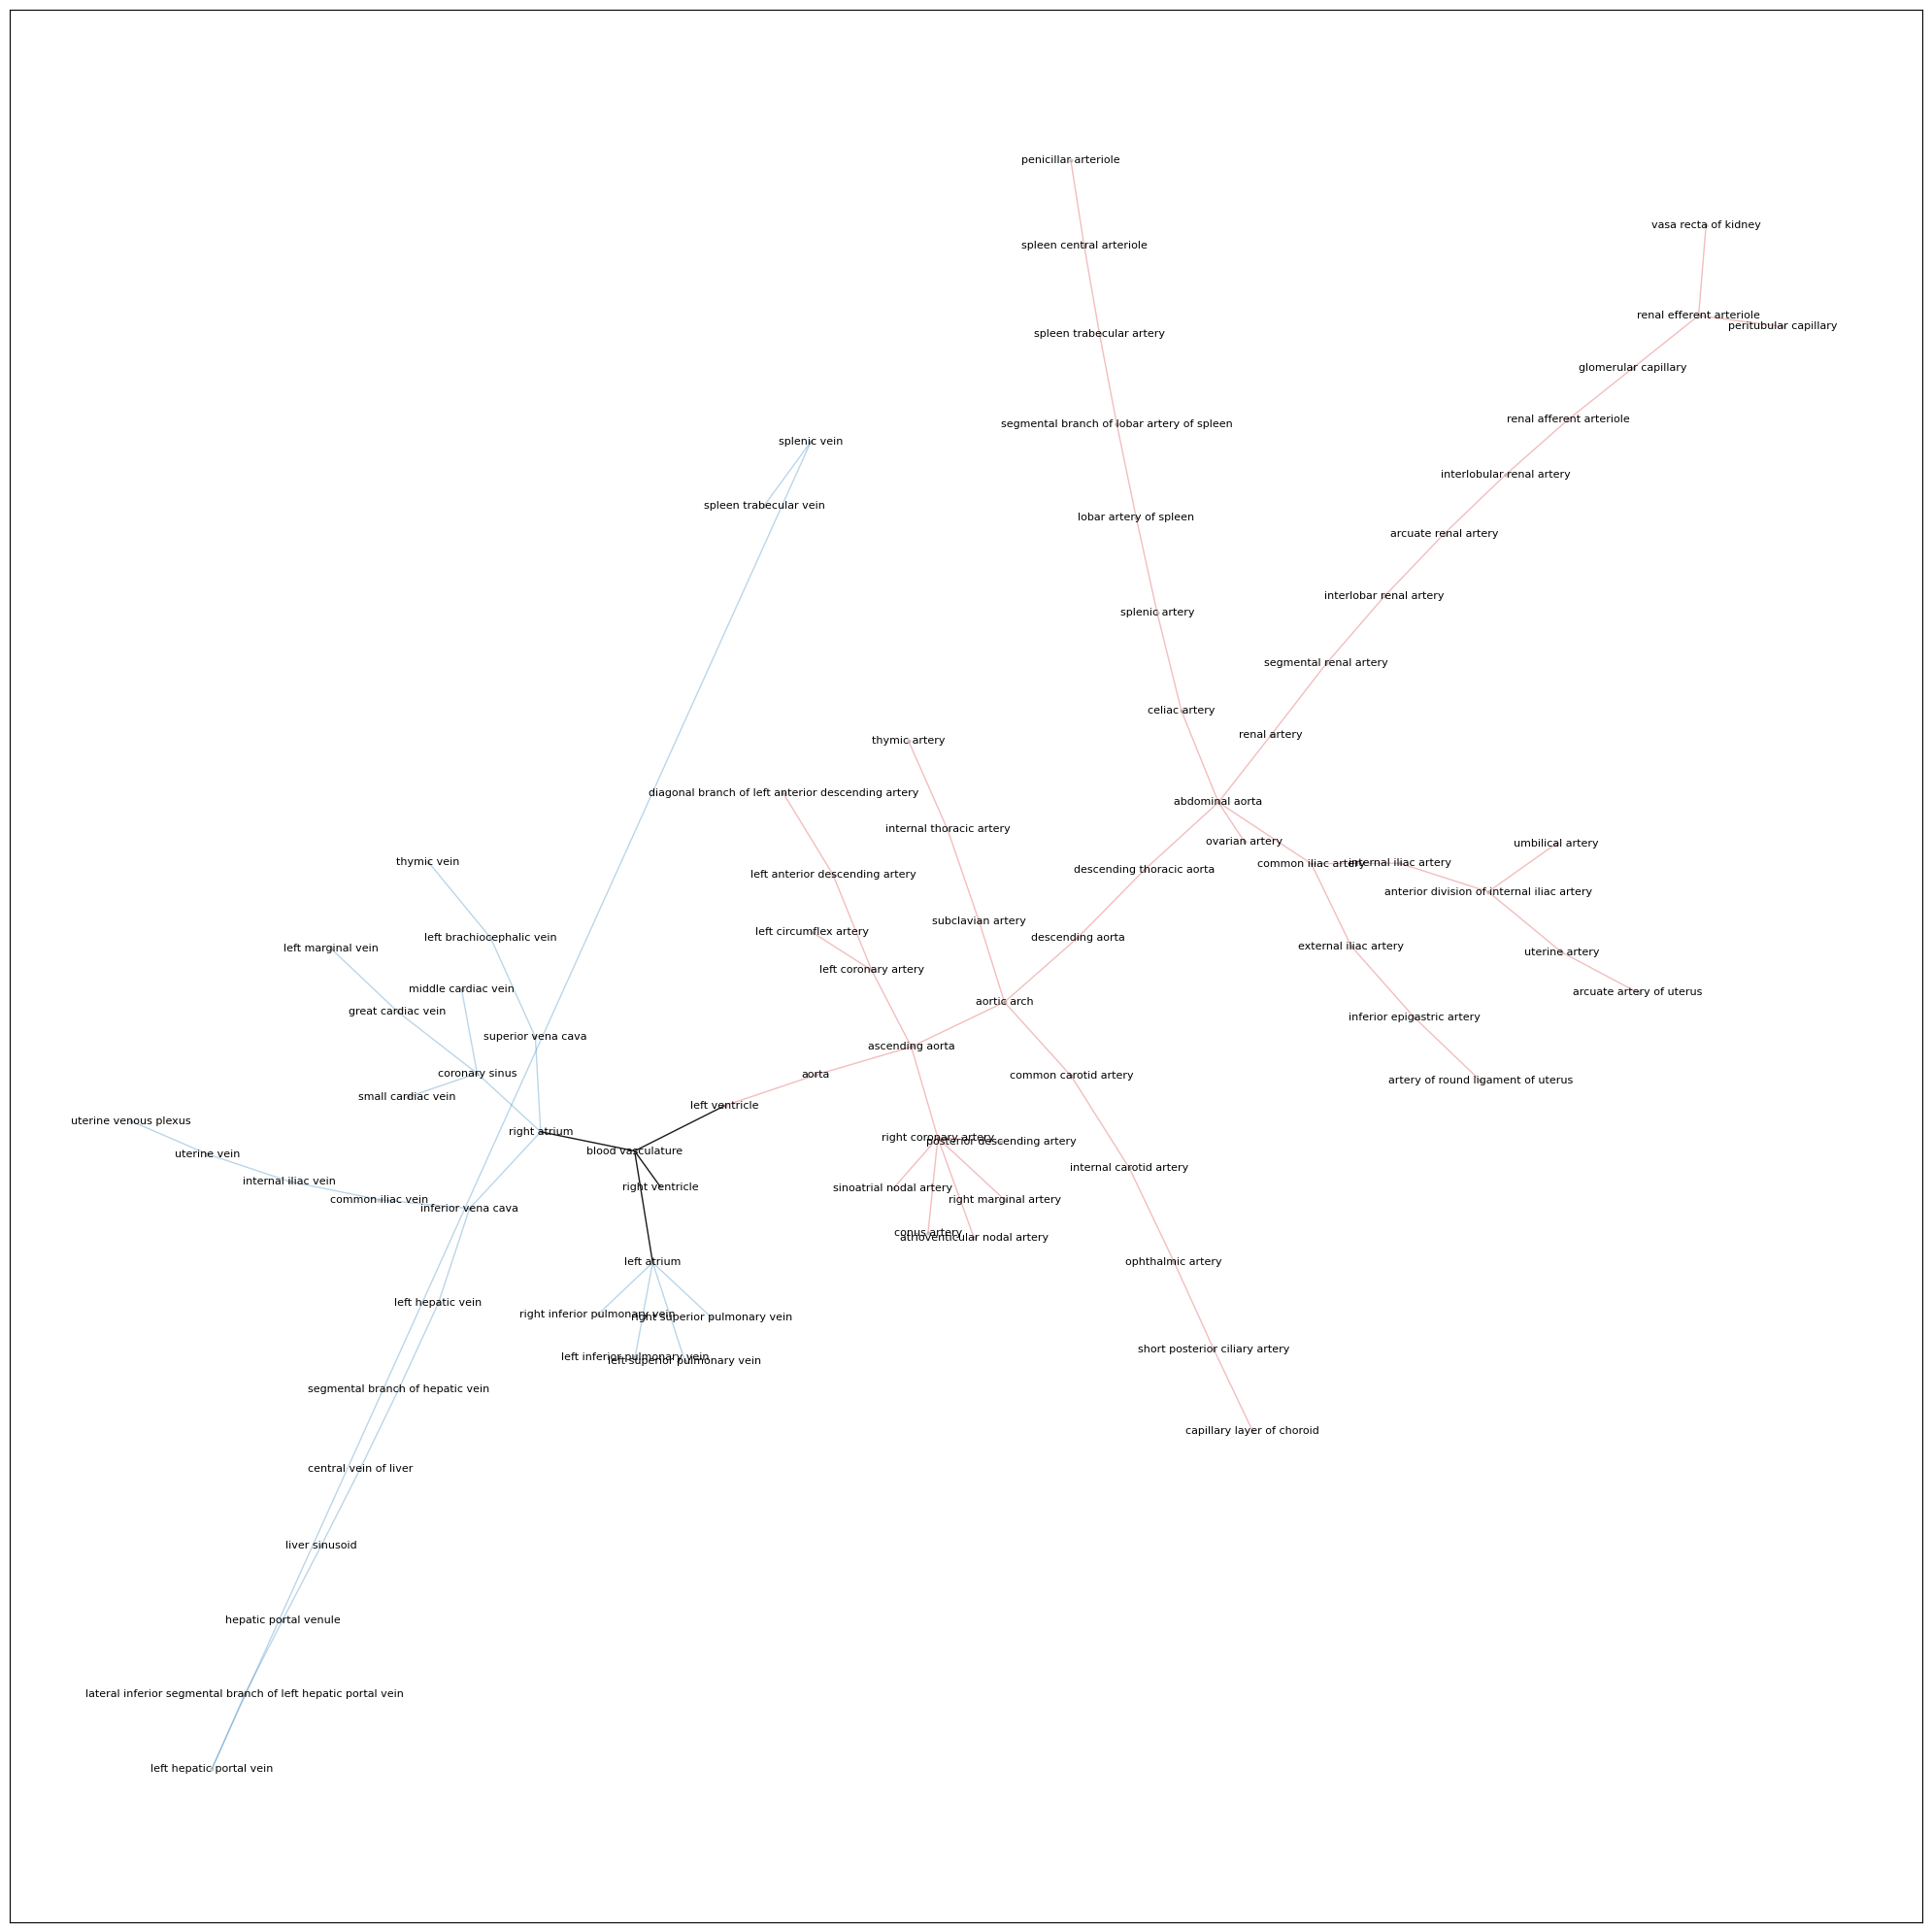

In [142]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(subgraph, pos=pos, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_labels(subgraph, pos=pos, font_size=8)
nx.draw_networkx_edges(subgraph, pos=pos, edgelist=new_edges, alpha=0.9)

colors = ['tab:red', 'tab:blue', 'tab:blue', 'tab:red']
for idx, comp in enumerate(connected_comps):
    nx.draw_networkx_edges(comp, pos=pos_of_pruned, alpha=0.3, edge_color=colors[idx])

plt.tight_layout()
plt.savefig('completed_vascular_v14.png', dpi=350)
plt.show()

In [143]:
new_edges

[('left atrium', 'blood vasculature'),
 ('left ventricle', 'blood vasculature'),
 ('right ventricle', 'blood vasculature'),
 ('blood vasculature', 'right atrium')]

In [144]:
[edge for edge in pruned_vasc_graph.edges if edge[0] in ['hepatic portal vein']]

[('hepatic portal vein', 'left hepatic portal vein'),
 ('hepatic portal vein', 'splenic vein')]

### add edges

In [145]:
pruned_vasc_graph_comp = pruned_vasc_graph.copy()

In [146]:
pruned_vasc_graph_comp.add_edges_from([('blood vasculature', 'left atrium'),('blood vasculature', 'left ventricle'),
                                       ('blood vasculature', 'right atrium'), ('blood vasculature', 'right ventricle')])

In [147]:
connected_comps[2].nodes

NodeView(('right inferior pulmonary vein', 'left atrium', 'left superior pulmonary vein', 'left inferior pulmonary vein', 'right superior pulmonary vein'))

In [148]:
veins = [node for node in pruned_vasc_graph_comp if (node not in connected_comps[0]) and (node not in connected_comps[3])]

In [149]:
veins

['uterine vein',
 'small cardiac vein',
 'left atrium',
 'great cardiac vein',
 'hepatic portal vein',
 'left marginal vein',
 'uterine venous plexus',
 'internal iliac vein',
 'left hepatic portal vein',
 'lateral inferior segmental branch of left hepatic portal vein',
 'segmental branch of hepatic vein',
 'liver sinusoid',
 'thymic vein',
 'superior vena cava',
 'left superior pulmonary vein',
 'inferior vena cava',
 'spleen trabecular vein',
 'left brachiocephalic vein',
 'splenic vein',
 'left inferior pulmonary vein',
 'right superior pulmonary vein',
 'central vein of liver',
 'right atrium',
 'right inferior pulmonary vein',
 'left hepatic vein',
 'coronary sinus',
 'common iliac vein',
 'middle cardiac vein',
 'hepatic portal venule',
 'blood vasculature']

In [150]:
arteries = [node for node in pruned_vasc_graph_comp if (node not in connected_comps[1]) and (node not in connected_comps[2])]

In [151]:
arteries

['spleen trabecular artery',
 'segmental branch of lobar artery of spleen',
 'common carotid artery',
 'arcuate renal artery',
 'aorta',
 'common iliac artery',
 'external iliac artery',
 'capillary layer of choroid',
 'vasa recta of kidney',
 'umbilical artery',
 'left ventricle',
 'interlobar renal artery',
 'renal afferent arteriole',
 'internal carotid artery',
 'right marginal artery',
 'renal efferent arteriole',
 'sinoatrial nodal artery',
 'abdominal aorta',
 'descending thoracic aorta',
 'glomerular capillary',
 'left circumflex artery',
 'lobar artery of spleen',
 'peritubular capillary',
 'subclavian artery',
 'posterior descending artery',
 'diagonal branch of left anterior descending artery',
 'ophthalmic artery',
 'right coronary artery',
 'renal artery',
 'aortic arch',
 'uterine artery',
 'internal iliac artery',
 'right ventricle',
 'left anterior descending artery',
 'penicillar arteriole',
 'ascending aorta',
 'atrioventicular nodal artery',
 'segmental renal artery'

In [152]:
pos = nx.drawing.nx_pydot.graphviz_layout(pruned_vasc_graph_comp, root='blood vasculature')

C:\Users\admin\AppData\Local\Temp\ipykernel_17172\539423552.py:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.drawing.nx_pydot.graphviz_layout(pruned_vasc_graph_comp, root='blood vasculature')


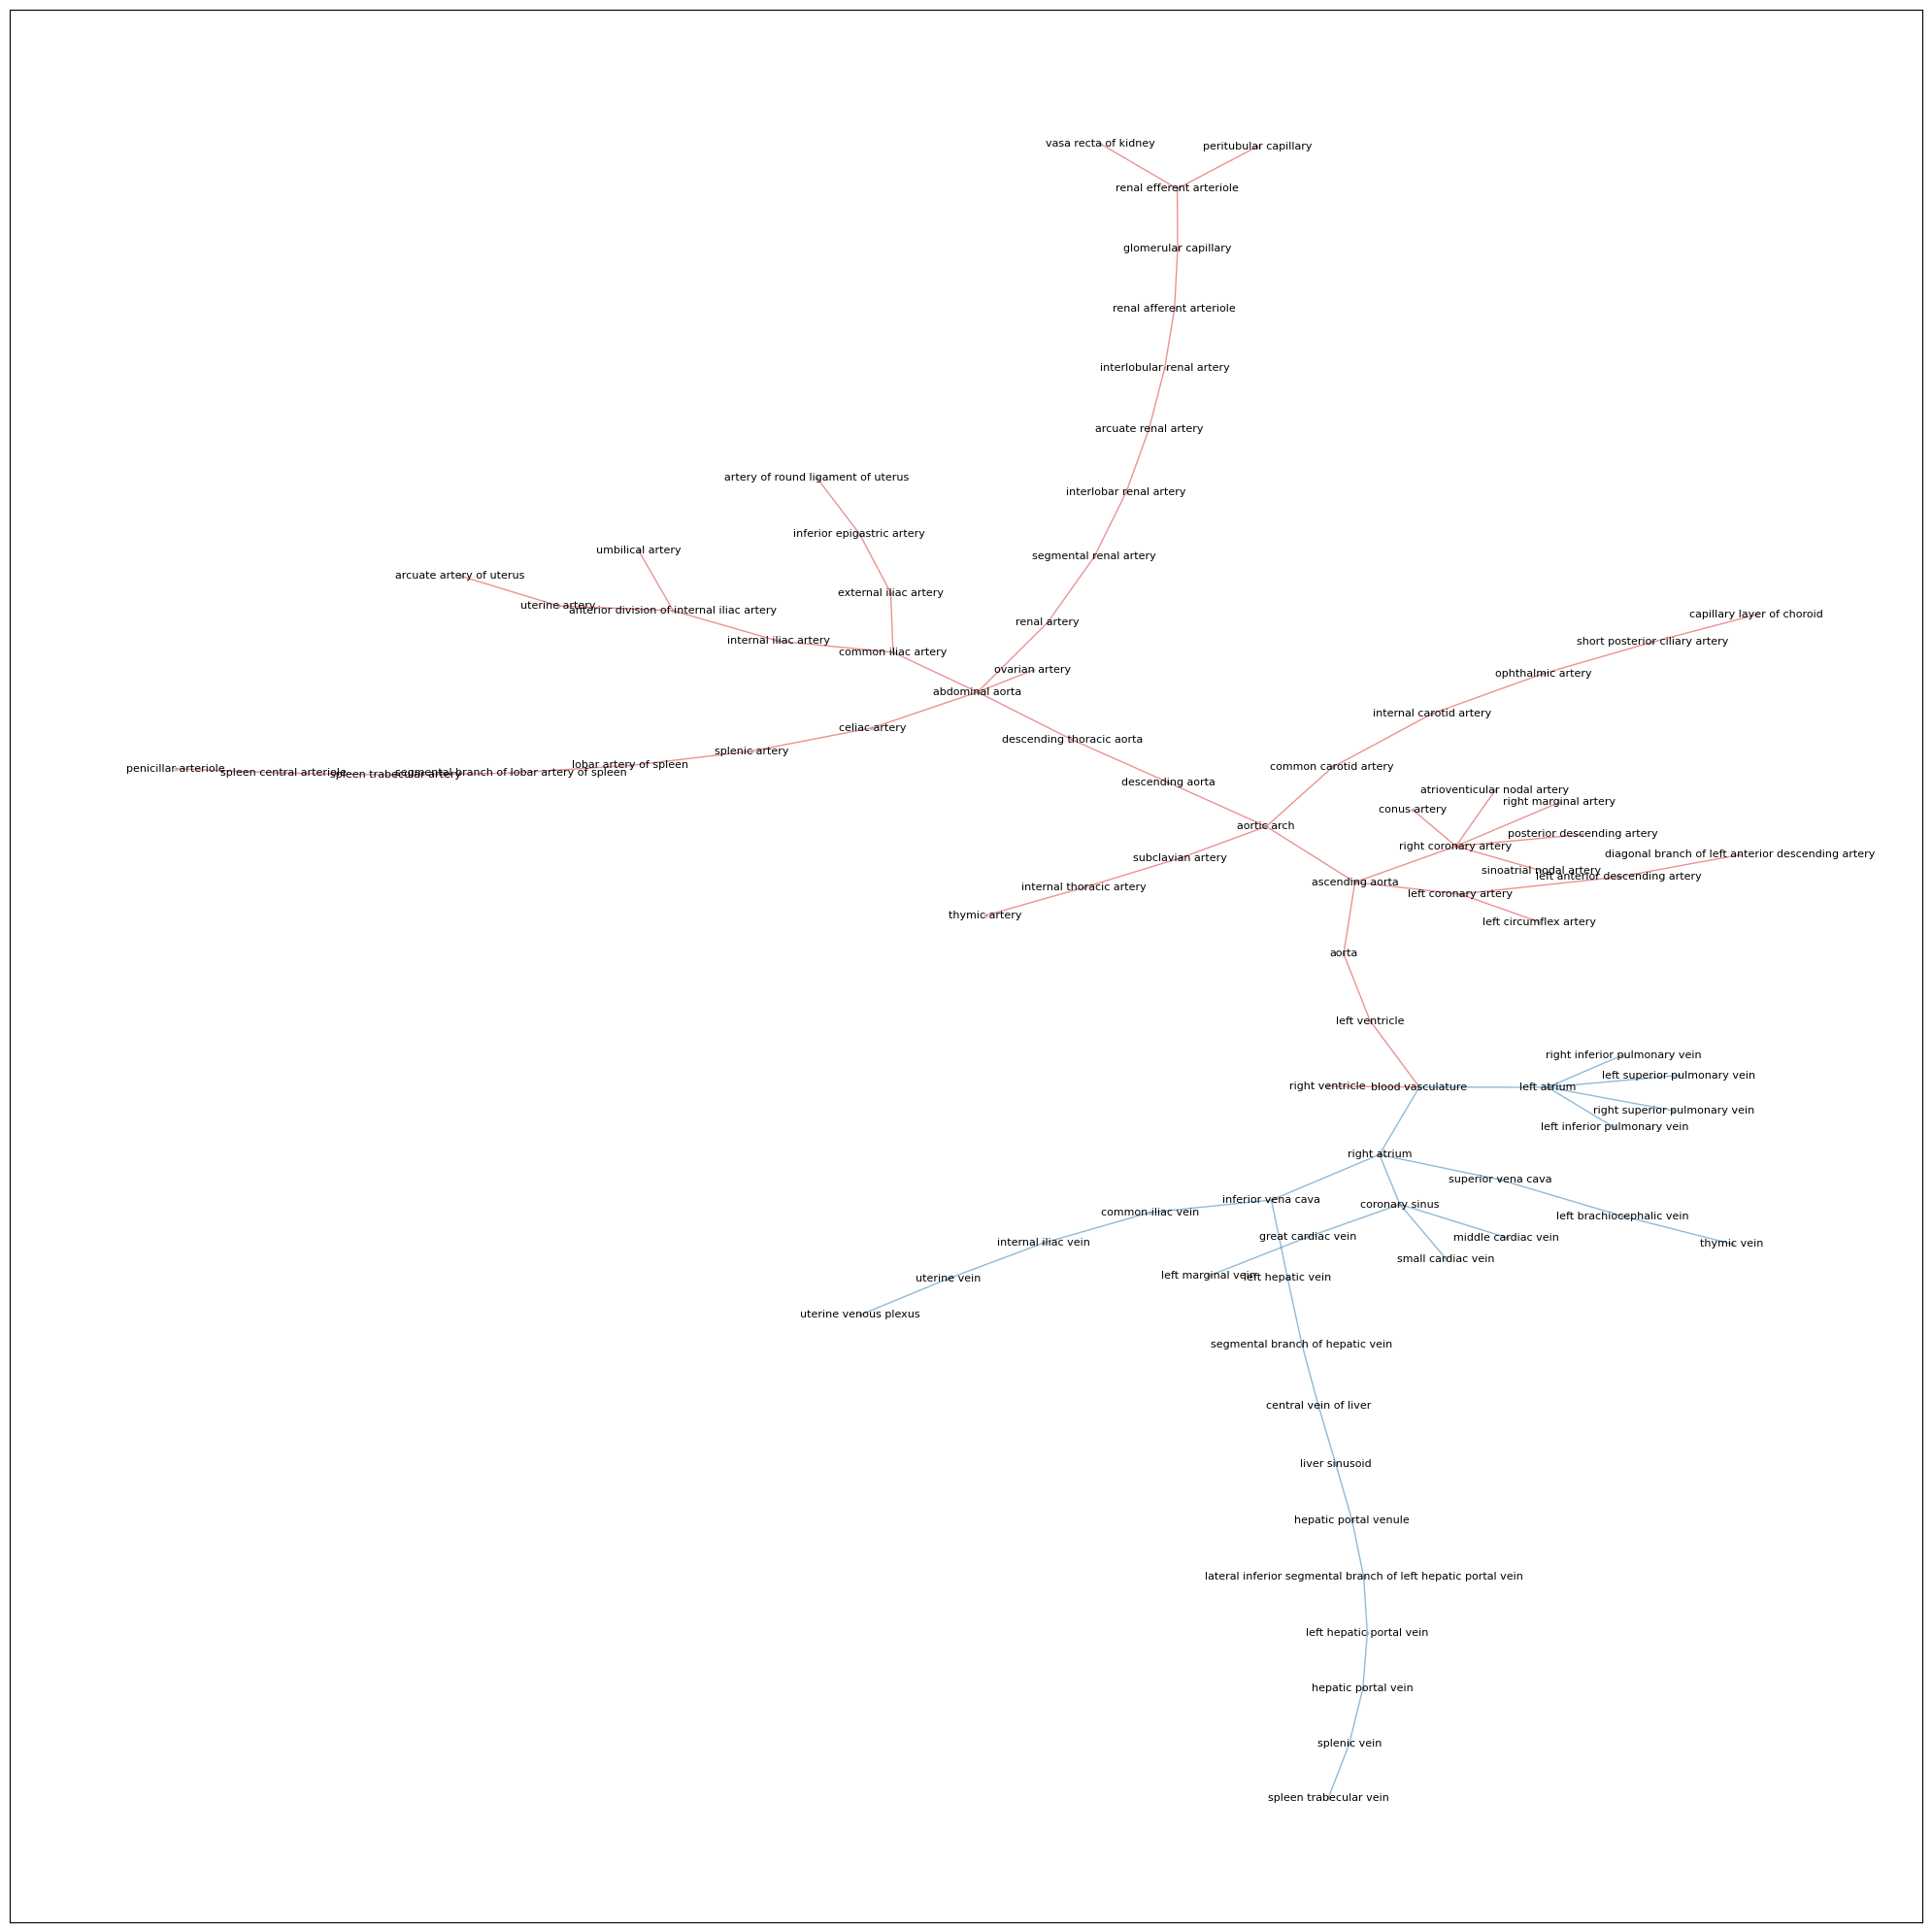

In [153]:
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(pruned_vasc_graph_comp, pos=pos, node_size=5, node_color='tab:grey', alpha=0.3)
nx.draw_networkx_labels(pruned_vasc_graph_comp, pos=pos, font_size=8)
# nx.draw_networkx_edges(subgraph, pos=pos, edgelist=new_edges, alpha=0.9)

nx.draw_networkx_edges(nx.induced_subgraph(pruned_vasc_graph_comp, veins), pos=pos, alpha=0.5, edge_color='tab:blue')
nx.draw_networkx_edges(nx.induced_subgraph(pruned_vasc_graph_comp, arteries), pos=pos, alpha=0.5, edge_color='tab:red')

plt.tight_layout()
plt.savefig('completed_vascular_v14.png', dpi=350)
plt.show()

# Female and male vascular network 

In [154]:
vasc_data.BodyPart.unique()

array(['heart chamber', 'lung', 'abdominal cavity;thoracic cavity',
       'thoracic cavity', 'neck', 'ear', 'head', 'face', 'thyroid gland',
       'brain', 'pituitary gland', 'eye', 'abdominal cavity', 'liver',
       'stomach;small intestine', 'small intestine', 'stomach',
       'pancreas;small intestine', 'esophagus', 'spleen', 'pancreas',
       'pelvis', 'leg', 'abdominal wall', 'foot', 'uterus', 'penis',
       'urinary bladder', 'clitoris', 'vagina', 'scrotum',
       'large intestine', 'diaphragm', 'adrenal gland', 'ovary', 'kidney',
       'testis', 'spinal cord', 'ureter', 'thoracic wall', 'heart',
       'shoulder', 'arm', 'hand', 'thymus', 'brainstem', 'cerebellum',
       'rectum', 'larynx', 'nose'], dtype=object)

In [200]:
female_vessels = vasc_data[vasc_data.BodyPart.isin(['clitoris', 'ovary', 'uterus', 'vagina'])] 

In [201]:
male_vessels = vasc_data[vasc_data.BodyPart.isin(['penis', 'scrotum', 'testis'])]

In [202]:
pruned_vasc_graph_comp_male = nx.induced_subgraph(pruned_vasc_graph_comp, [node for node in pruned_vasc_graph_comp if node not in female_vessels.Vessel.values])

In [203]:
pruned_vasc_graph_comp_female = nx.induced_subgraph(pruned_vasc_graph_comp, [node for node in pruned_vasc_graph_comp if node not in male_vessels.Vessel.values])

In [204]:
nx.write_gml(pruned_vasc_graph_comp_female, './viz_v14/pruned_vasc_graph_comp_female.gml')

In [205]:
nx.write_gml(pruned_vasc_graph_comp_male, './viz_v14/pruned_vasc_graph_comp_male.gml')

In [206]:
readojfwfoj=nx.read_gml('./viz_v14/pruned_vasc_graph_comp_male.gml')

In [207]:
set(list(readojfwfoj.edges()))==set(list(pruned_vasc_graph_comp_male.edges()))

True

In [208]:
pruned_vasc_graph_comp_female.number_of_edges()

82

In [209]:
len(pruned_vasc_graph_comp_male)

77

In [210]:
len(pruned_vasc_graph_comp_female)

83

In [211]:
len(pruned_vasc_graph_comp)

83

## Unfortunately, this does not work well for the matplotlib inline backend in Jupyter because that backend uses a different default of rcParams['figure.dpi'] = 72. Additionally, it saves the figure with bbox_inches='tight', which crops the figure and makes the actual size unpredictable.

https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html

# So it is not recommended to run in Jupyter but it works fine in PyCharm / DataSpell

In [212]:
def plot_fixed_graph2(graph, viz, bundle_edges=False, draw_labels=False, filename='vasculature'):
    graphs = {'veins': nx.induced_subgraph(graph, veins), 'arteries': nx.induced_subgraph(graph, arteries)}
    coords = {'veins': get_coordinates_4_vessels(viz, graphs['veins']), 'arteries': get_coordinates_4_vessels(viz, graphs['arteries'])}
    relabel_mapping_inv = {'veins': coords['veins']['name_in_vasc'].to_dict(), 'arteries': coords['arteries']['name_in_vasc'].to_dict()}
    relabel_mapping =  {'veins': {v: k for k, v in relabel_mapping_inv['veins'].items()}, 'arteries':{v: k for k, v in relabel_mapping_inv['arteries'].items()}}
    # {'veins': , 'arteries': }
    renamed_comp = {'veins': nx.relabel_nodes(graphs['veins'], relabel_mapping['veins']), 'arteries': nx.relabel_nodes(graphs['arteries'], relabel_mapping['arteries']) } 
    
    pos = {'veins': coords['veins']['coords'].dropna().to_dict(), 'arteries': coords['arteries']['coords'].dropna().to_dict()}
    pos['veins'][relabel_mapping['veins']['blood vasculature']] = np.array([body_x-10, -body_y])
    pos['arteries'][relabel_mapping['arteries']['blood vasculature']] = np.array([body_x-10, -body_y])
    pos2 = {'veins': nx.spring_layout(renamed_comp['veins'], pos=pos['veins'], fixed=list(pos['veins'].keys()), seed=10, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['veins']))), 
            'arteries': nx.spring_layout(renamed_comp['arteries'], pos=pos['arteries'], fixed=list(pos['arteries'].keys()), seed=10, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['arteries'])))}
    
    if not bundle_edges:
        plt.figure(figsize=(17.2,17.2))
        plt.axes().set_aspect('equal')
        plt.margins(x=0, y=0)
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off') 
        nx.draw(renamed_comp['veins'], pos2['veins'], node_size=10, edge_color='tab:blue', node_color='tab:blue')
        nx.draw(renamed_comp['arteries'], pos2['arteries'], node_size=10, edge_color='tab:red', node_color='tab:red')
        if draw_labels:
            nx.draw_networkx_labels(renamed_comp['veins'], pos2['veins'], labels=relabel_mapping_inv['veins'], font_size=3)
            nx.draw_networkx_labels(renamed_comp['arteries'], pos2['arteries'], labels=relabel_mapping_inv['arteries'], font_size=3)
        # nx.draw_networkx_nodes(renamed_comp, pos2, nodelist=list(pos.keys()), node_color='tab:orange', node_size=10)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.savefig(f'./viz_v14/{filename}_v14.pdf',  transparent=True, pad_inches=0.0, bbox_inches=0)
        plt.show()
    else:
        nodes_only = {'veins': pd.DataFrame.from_dict(relabel_mapping_inv['veins'], orient='index').rename(columns={0:'name'}), 
                      'arteries': pd.DataFrame.from_dict(relabel_mapping_inv['arteries'], orient='index').rename(columns={0:'name'})}
        
        nodes = {'veins': pd.DataFrame.from_dict(pos2['veins']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['veins'])[['name', 'x', 'y']], 
                 'arteries': pd.DataFrame.from_dict(pos2['arteries']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['arteries'])[['name', 'x', 'y']]}
        
        edges = {'veins': nx.to_pandas_edgelist(renamed_comp['veins'])[['source', 'target']], 
                 'arteries': nx.to_pandas_edgelist(renamed_comp['arteries'])[['source', 'target']]}
        # hb = hammer_bundle(nodes, edges, initial_bandwidth=0.03,tension=0.9, accuracy=8000)
        hb = {'veins': hammer_bundle(nodes['veins'], edges['veins'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000), 
              'arteries': hammer_bundle(nodes['arteries'], edges['arteries'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)}
        
        plt.figure(figsize=(17.2, 17.2))
        plt.axes().set_aspect('equal', anchor="NW")
        plt.margins(x=0, y=0)
        plt.xlim(0,1720)
        plt.ylim(-1720, 0)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)  
        plt.plot(hb['veins']['x'], hb['veins']['y'], color='tab:blue', alpha=0.8)
        plt.plot(hb['arteries']['x'], hb['arteries']['y'], color='tab:red', alpha=0.8)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.savefig(f'./viz_v14/{filename}_bundled_v14.pdf', pad_inches=0.0, transparent=True, bbox_inches=0)
        plt.show()

In [213]:
dpi = plt.rcParams['figure.dpi']

In [214]:
dpi

100.0

In [221]:
with open('viz_v14/female_wing_viz_v14.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [222]:
female_wing_viz = viz['data'][0]['values']

In [223]:
body_x = female_wing_viz[0]['x']
body_y = female_wing_viz[0]['y']

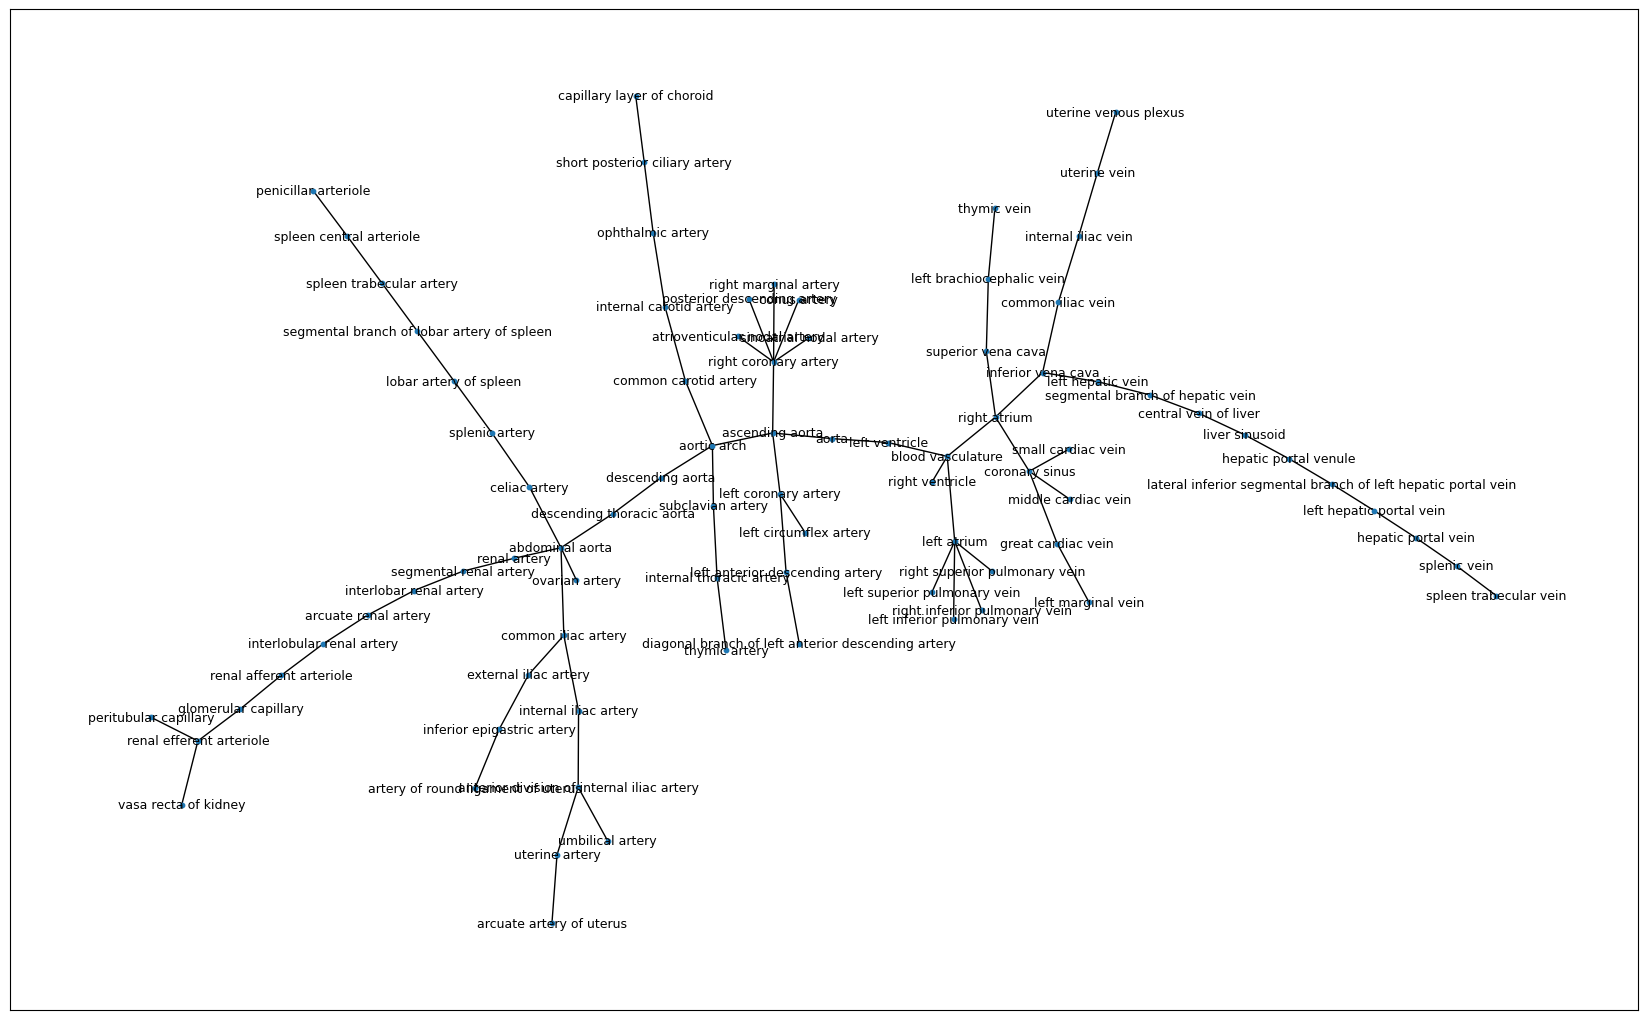

In [224]:
plt.figure(figsize=(21,13))
nx.draw_networkx(pruned_vasc_graph_comp_female, pos=nx.nx_agraph.graphviz_layout(pruned_vasc_graph_comp_female), node_size=10, font_size=9)

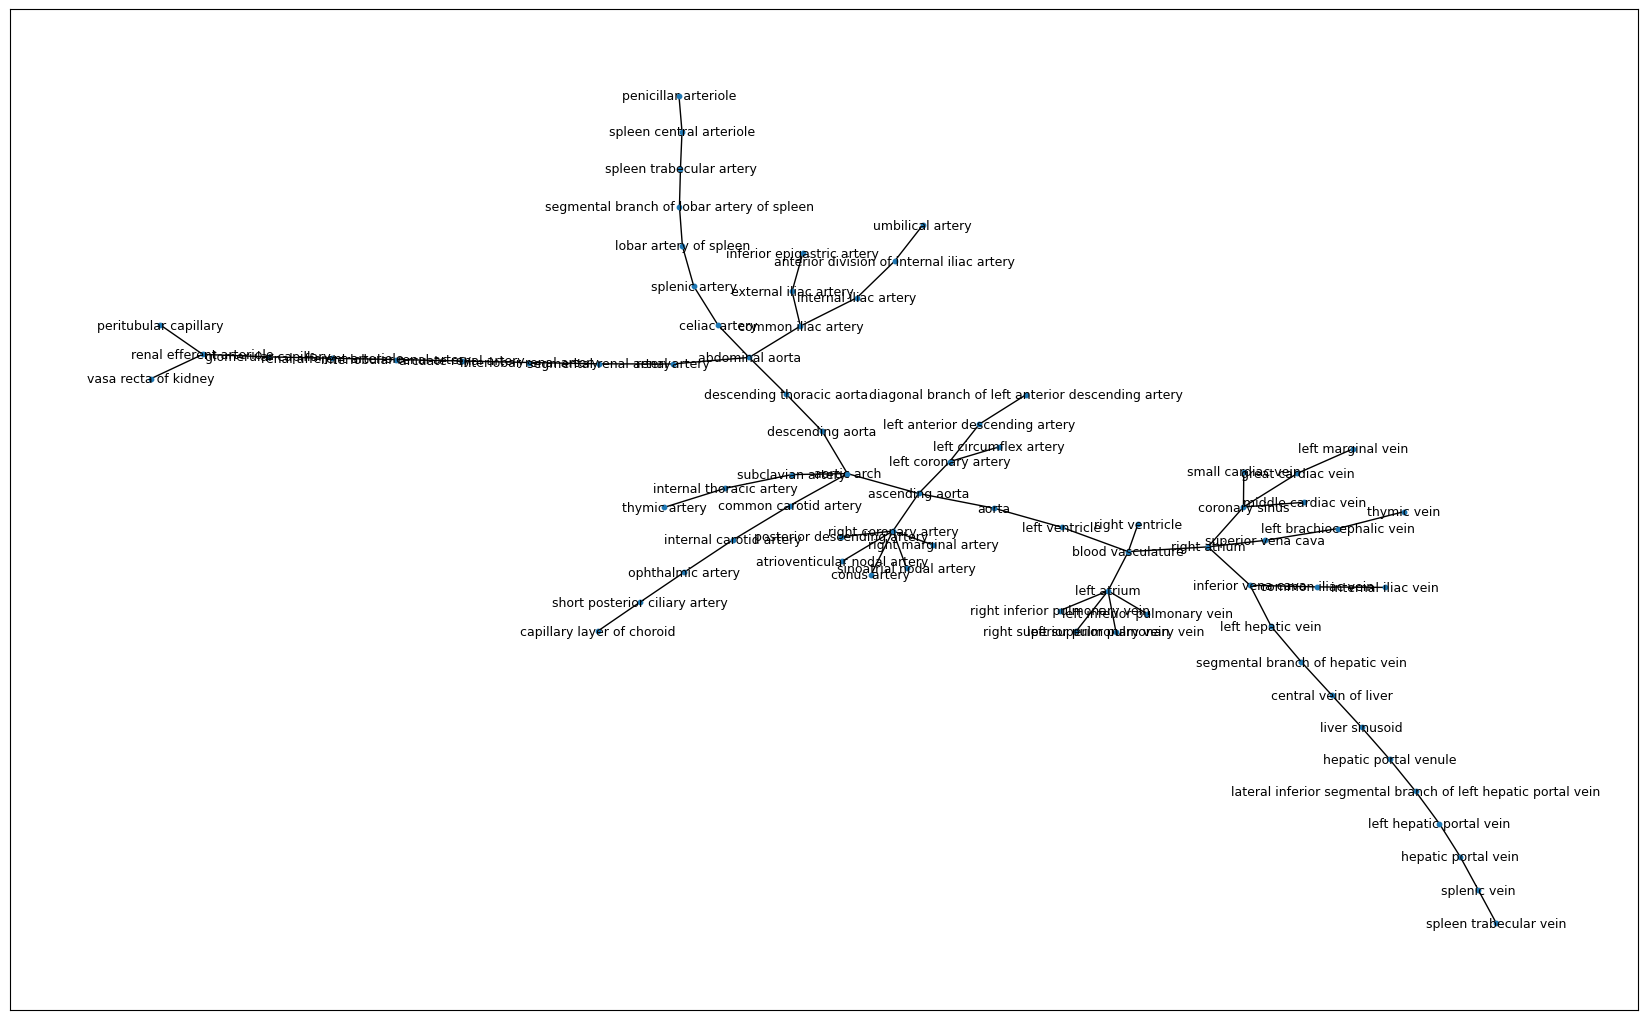

In [225]:
plt.figure(figsize=(21,13))
nx.draw_networkx(pruned_vasc_graph_comp_male, pos=nx.nx_agraph.graphviz_layout(pruned_vasc_graph_comp_male), node_size=10, font_size=9)

C:\Users\admin\AppData\Local\Temp\ipykernel_17172\4083130170.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))


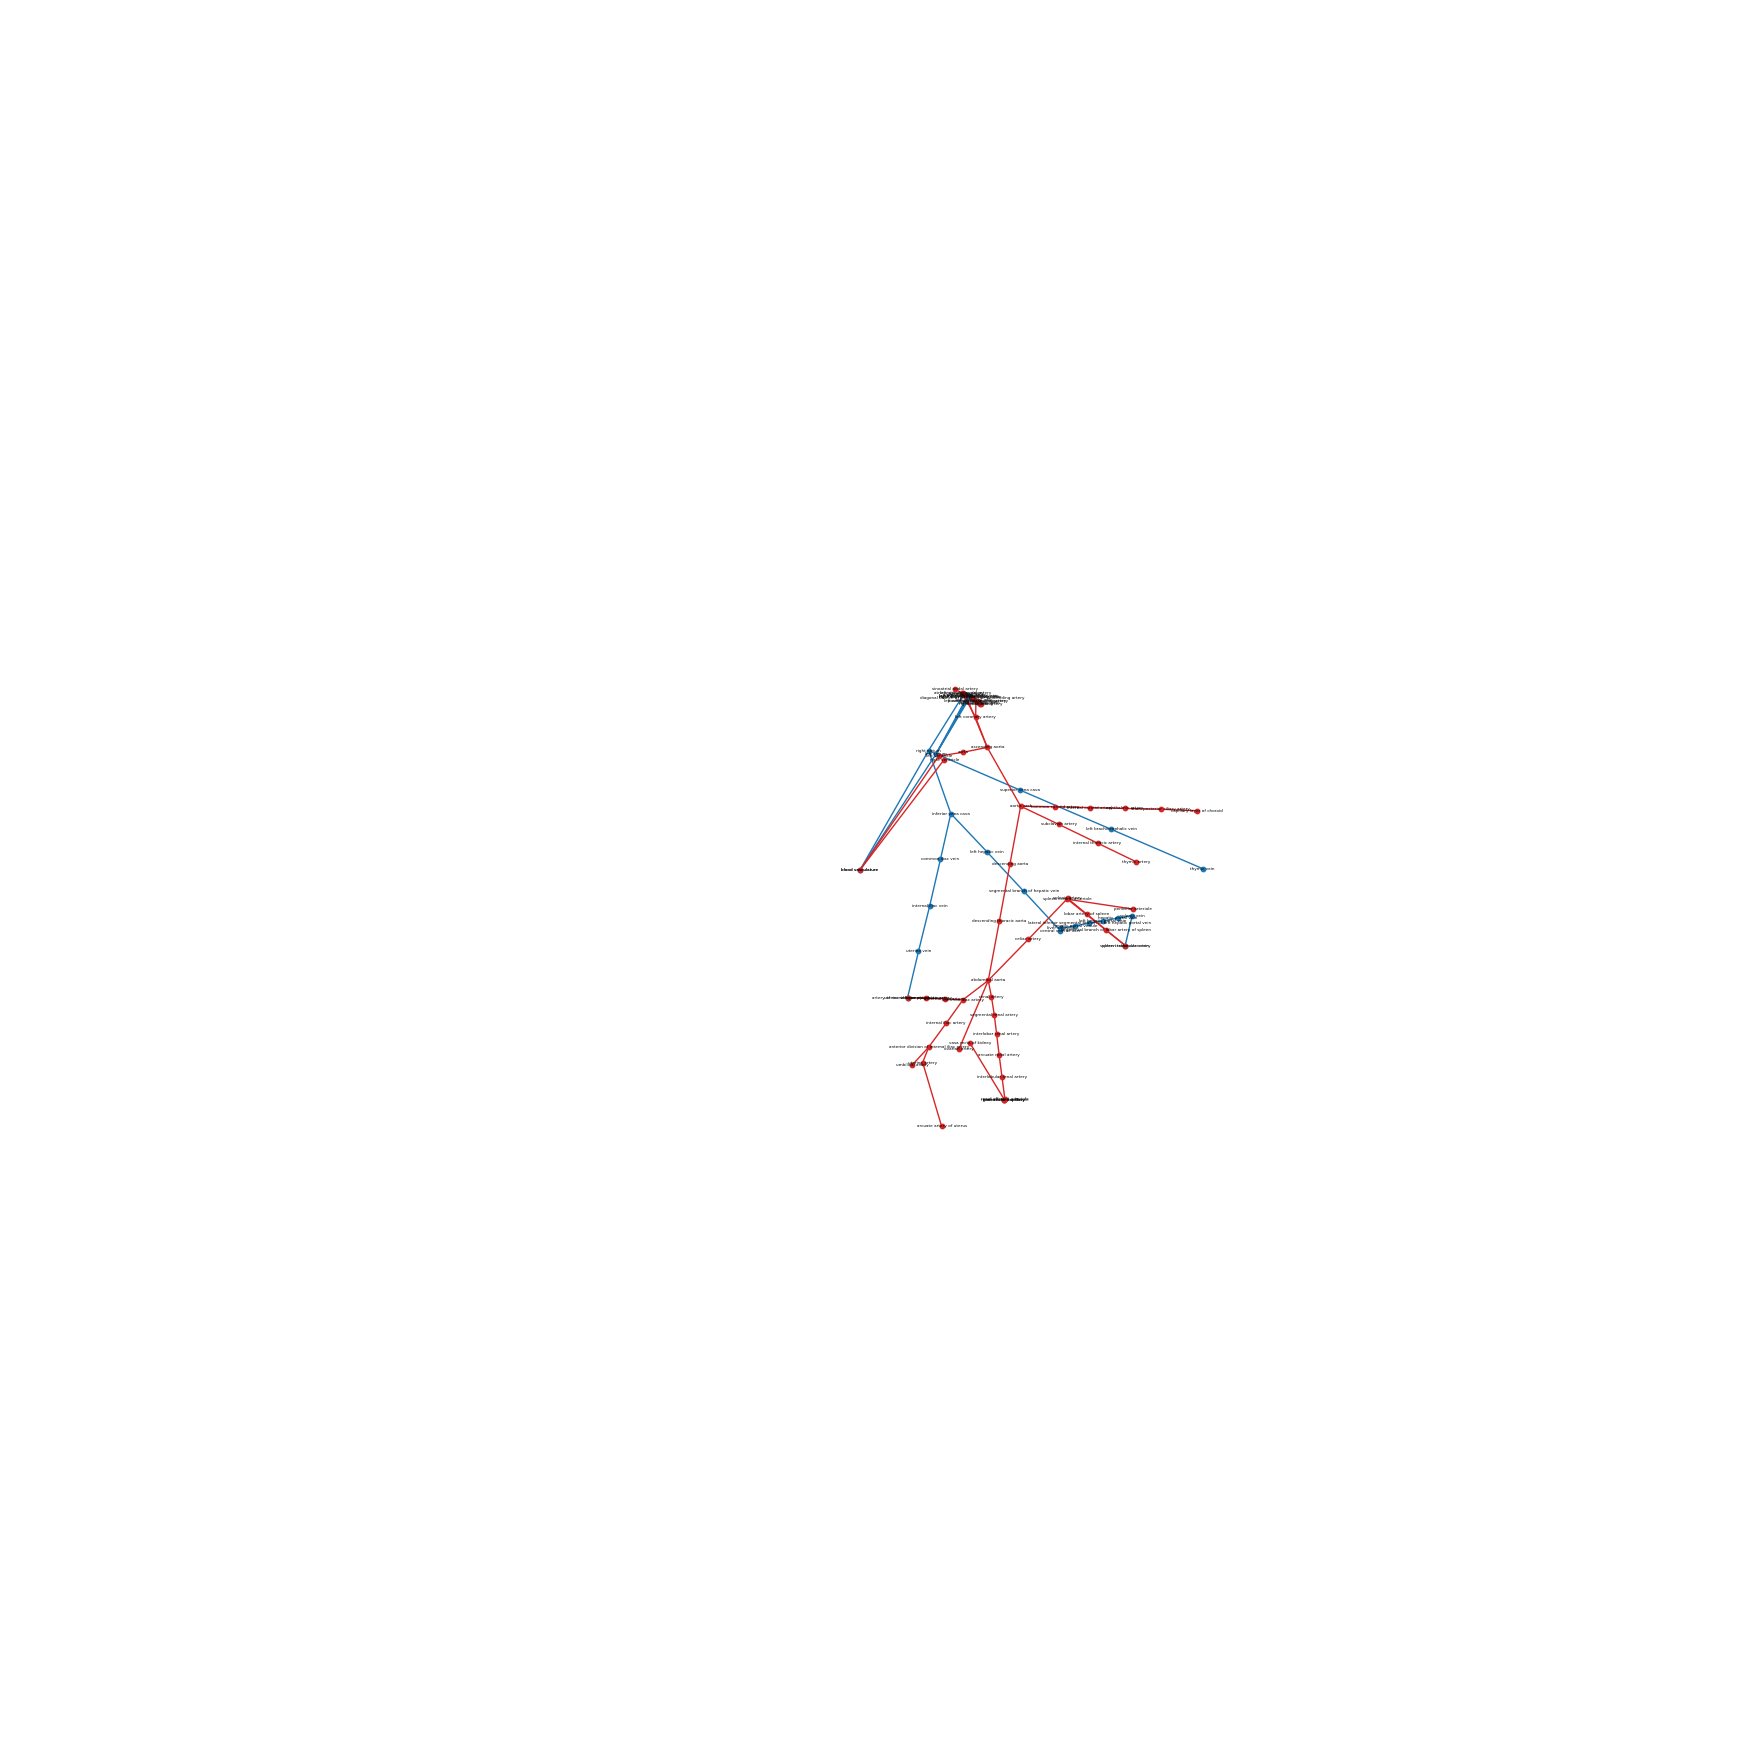

In [227]:
plot_fixed_graph2(pruned_vasc_graph_comp_female, female_wing_viz, draw_labels=True, filename='female_wing')

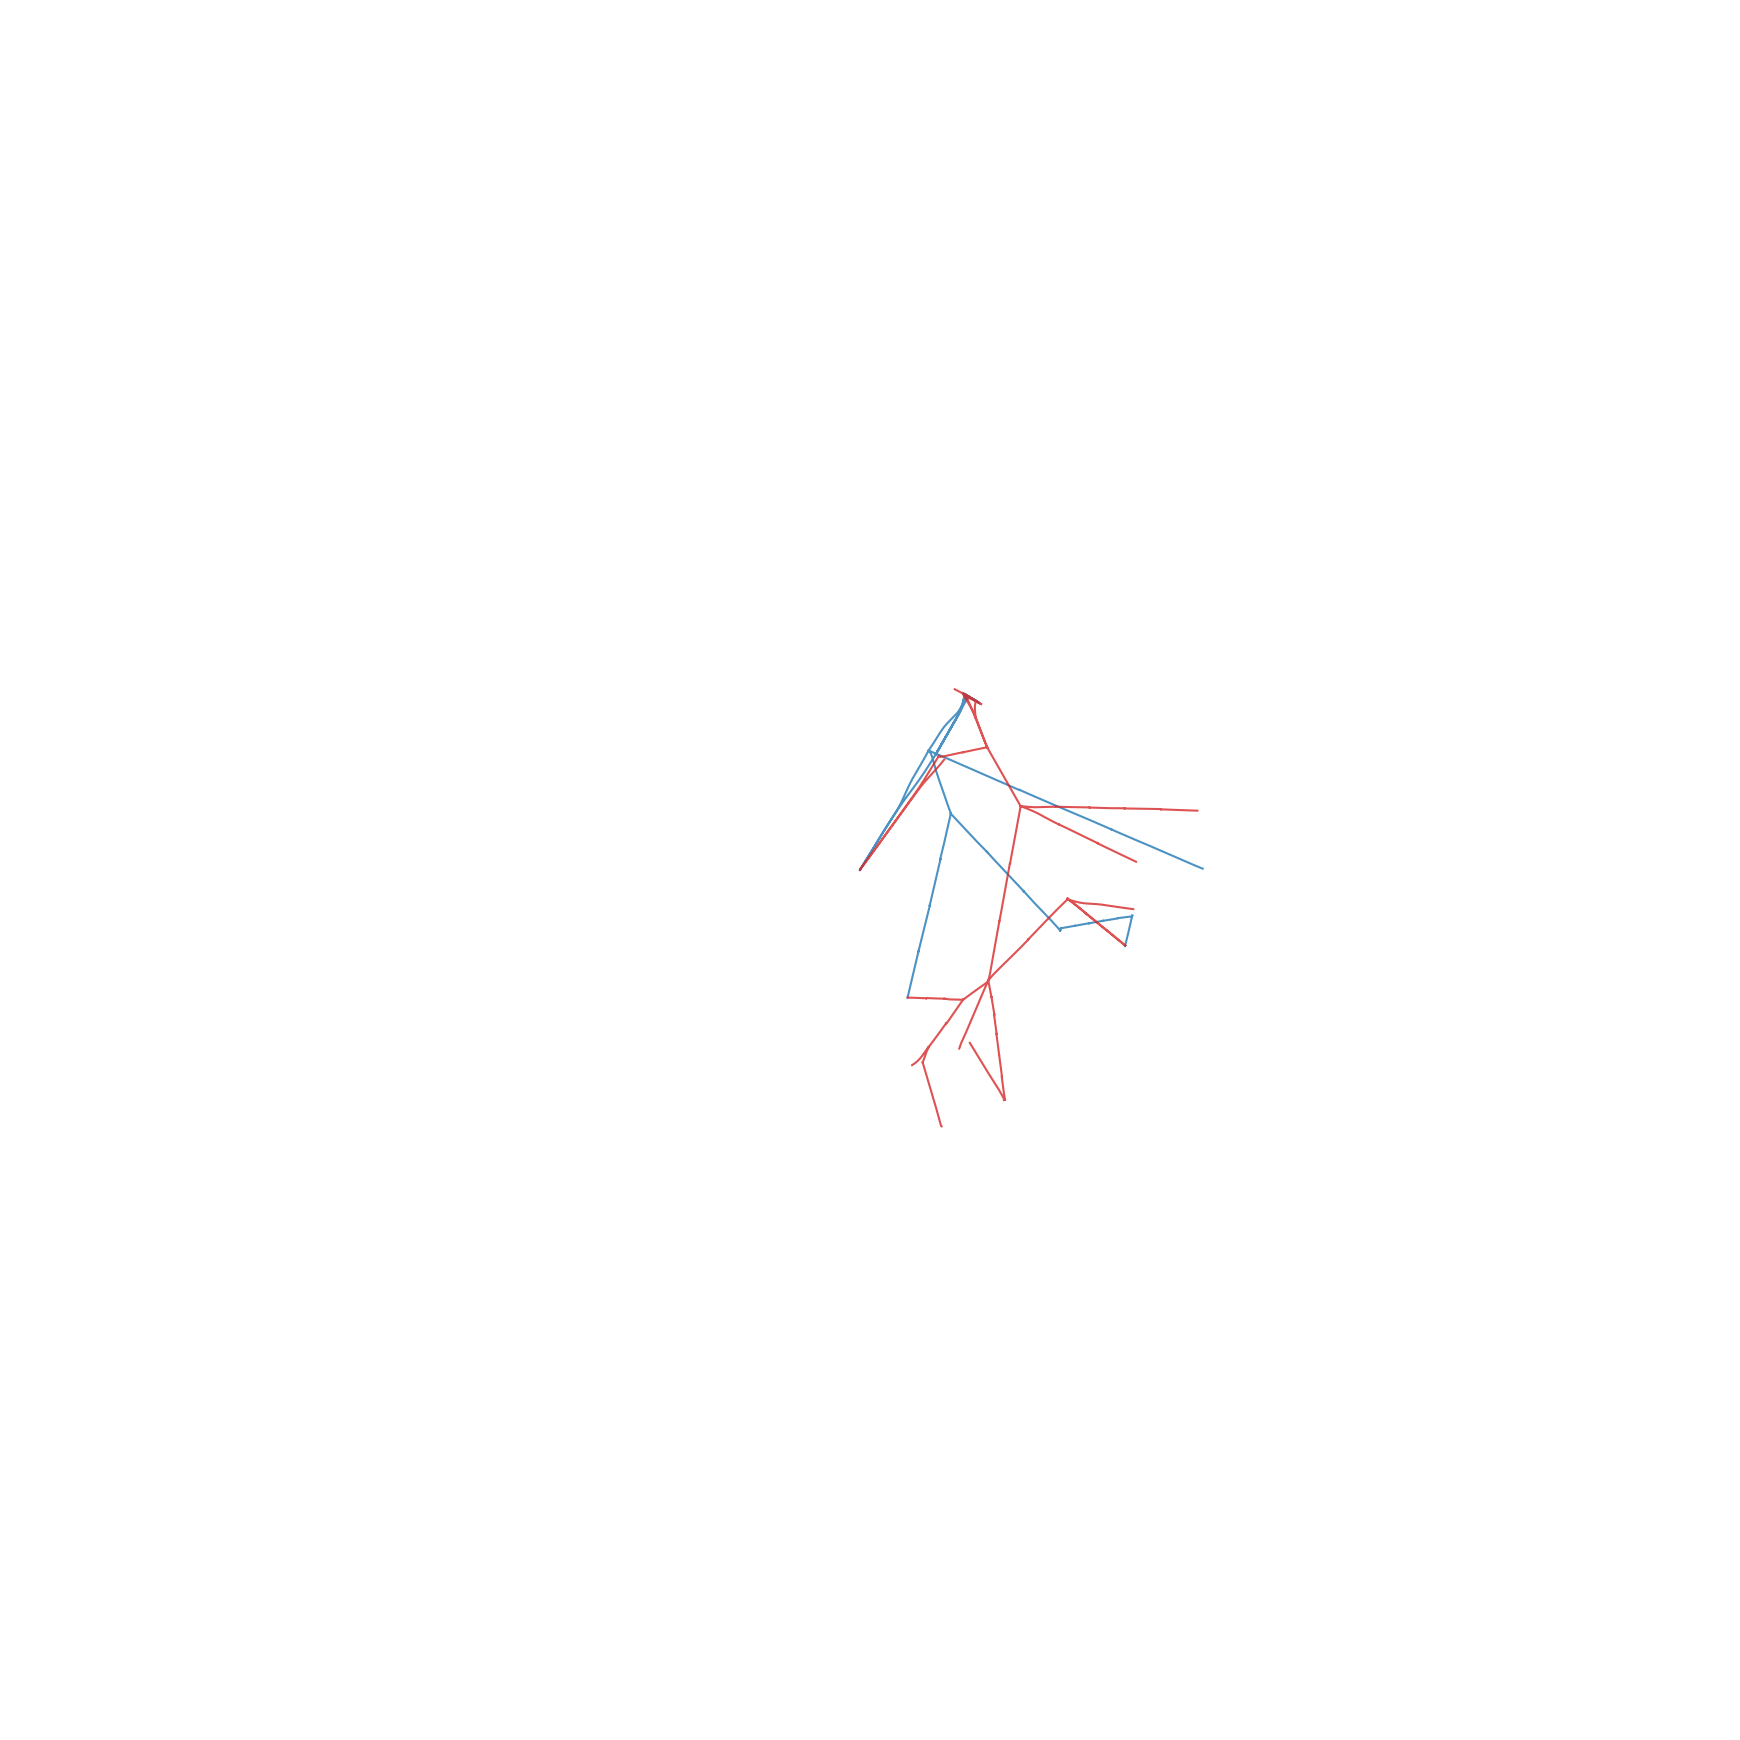

In [228]:
plot_fixed_graph2(pruned_vasc_graph_comp_female, female_wing_viz, bundle_edges=True, filename='female_wing')

In [229]:
with open('viz_v14/male_wing_viz_v14.json', encoding='utf8') as json_file:
    viz = json.load(json_file)

In [230]:
male_wing_viz = viz['data'][0]['values']

C:\Users\admin\AppData\Local\Temp\ipykernel_17172\4083130170.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))


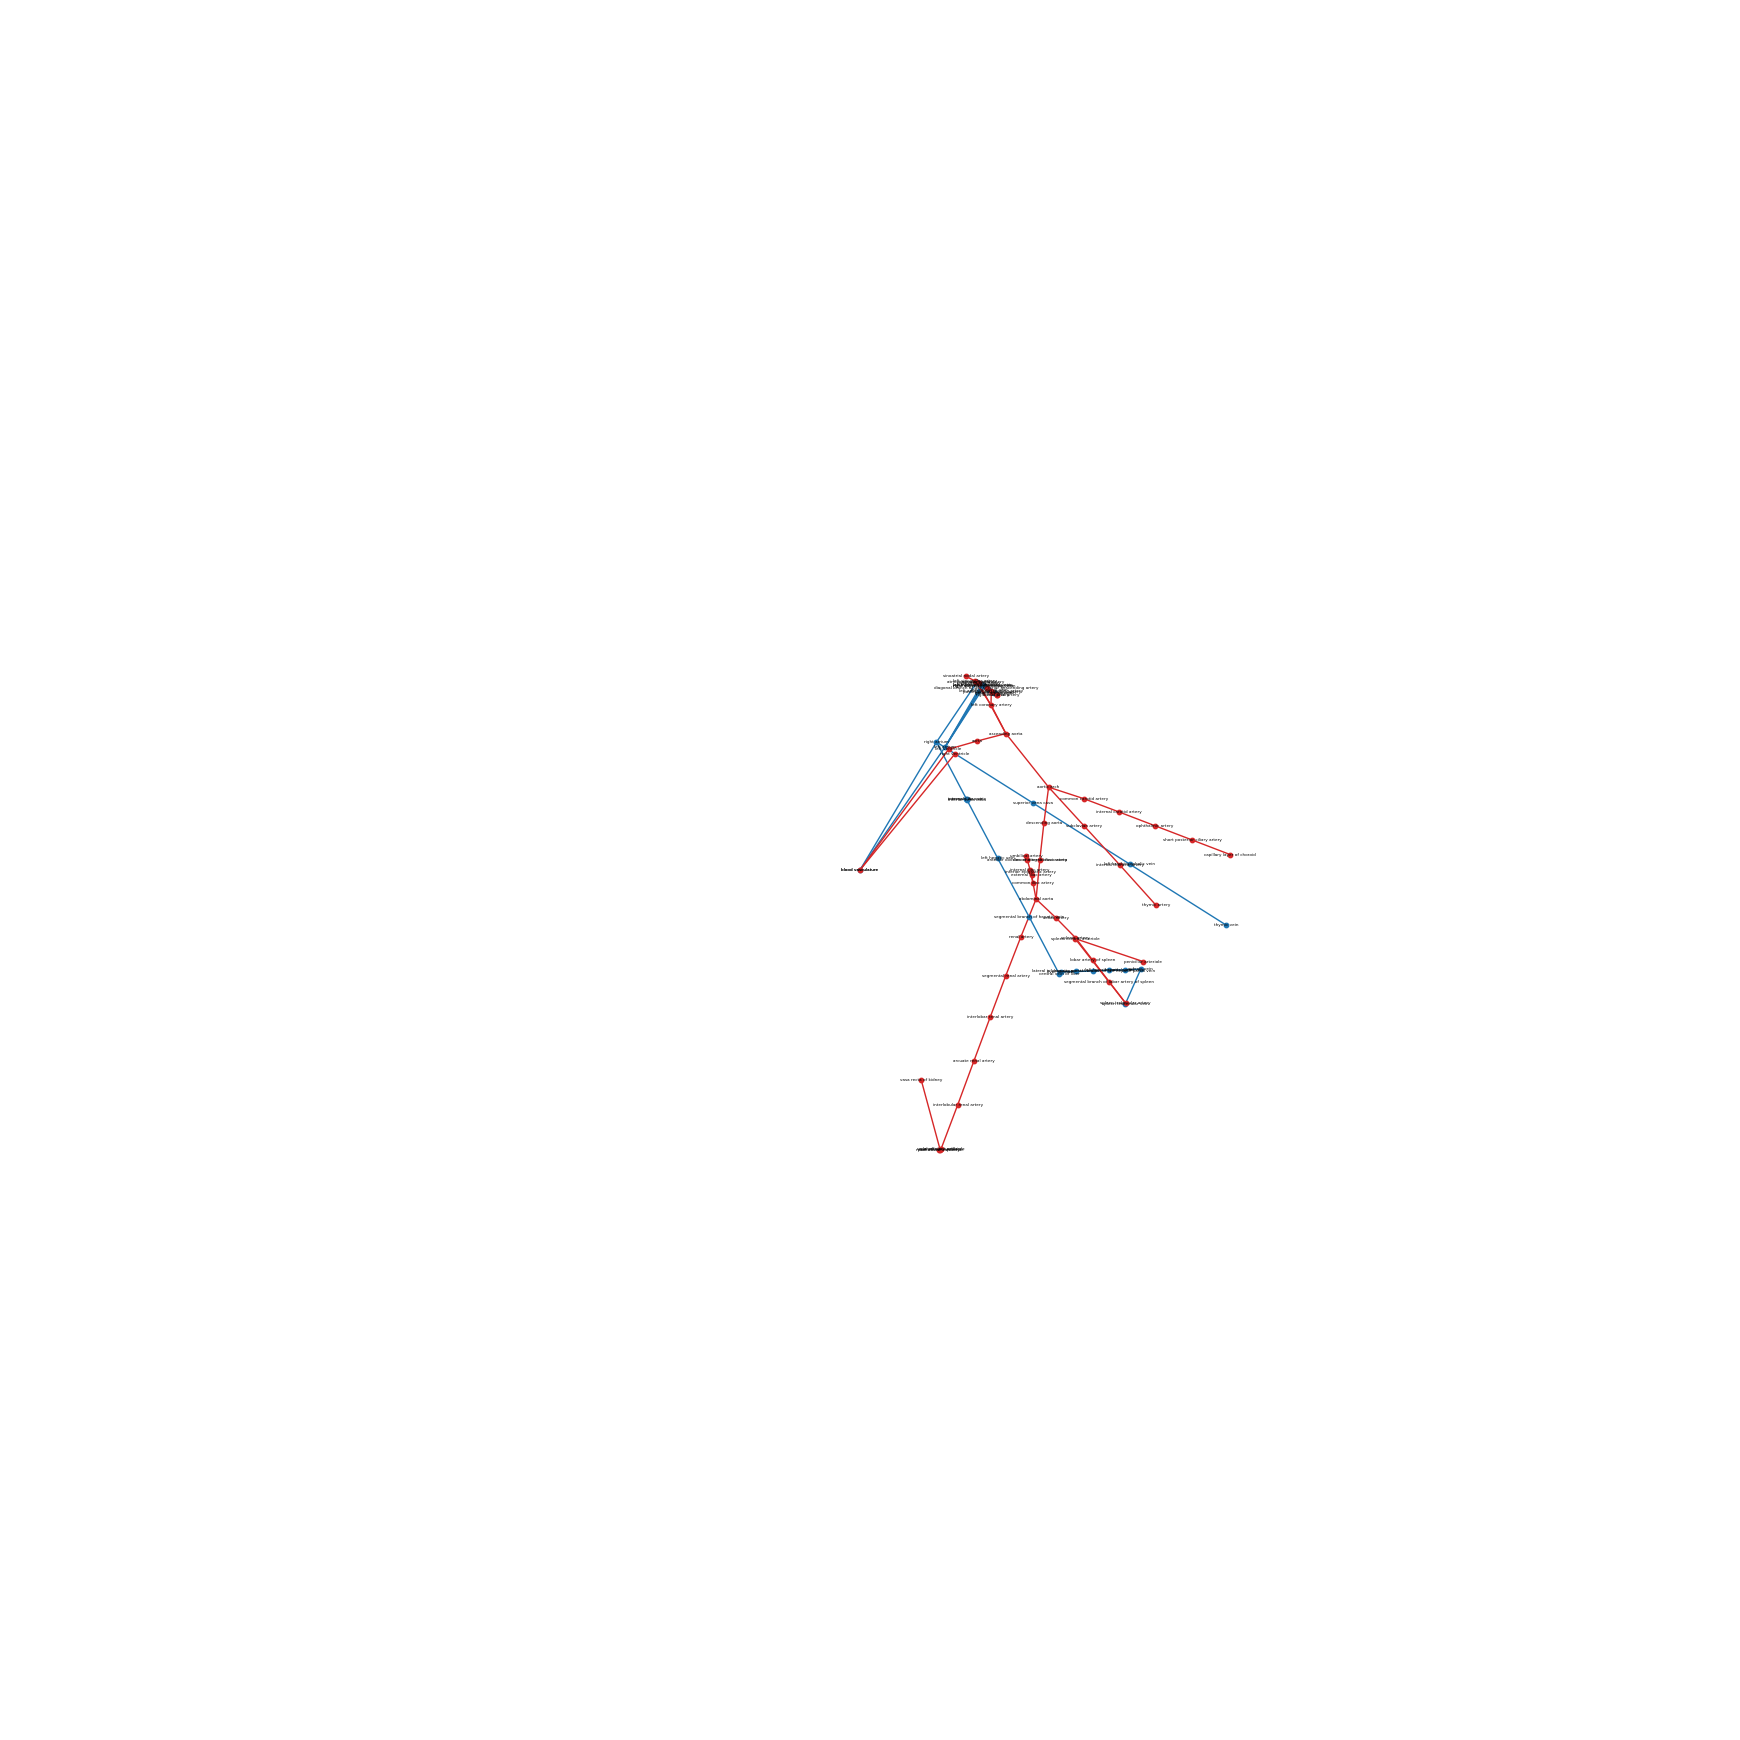

In [231]:
plot_fixed_graph2(pruned_vasc_graph_comp_male, male_wing_viz, draw_labels=True, filename='male_wing')

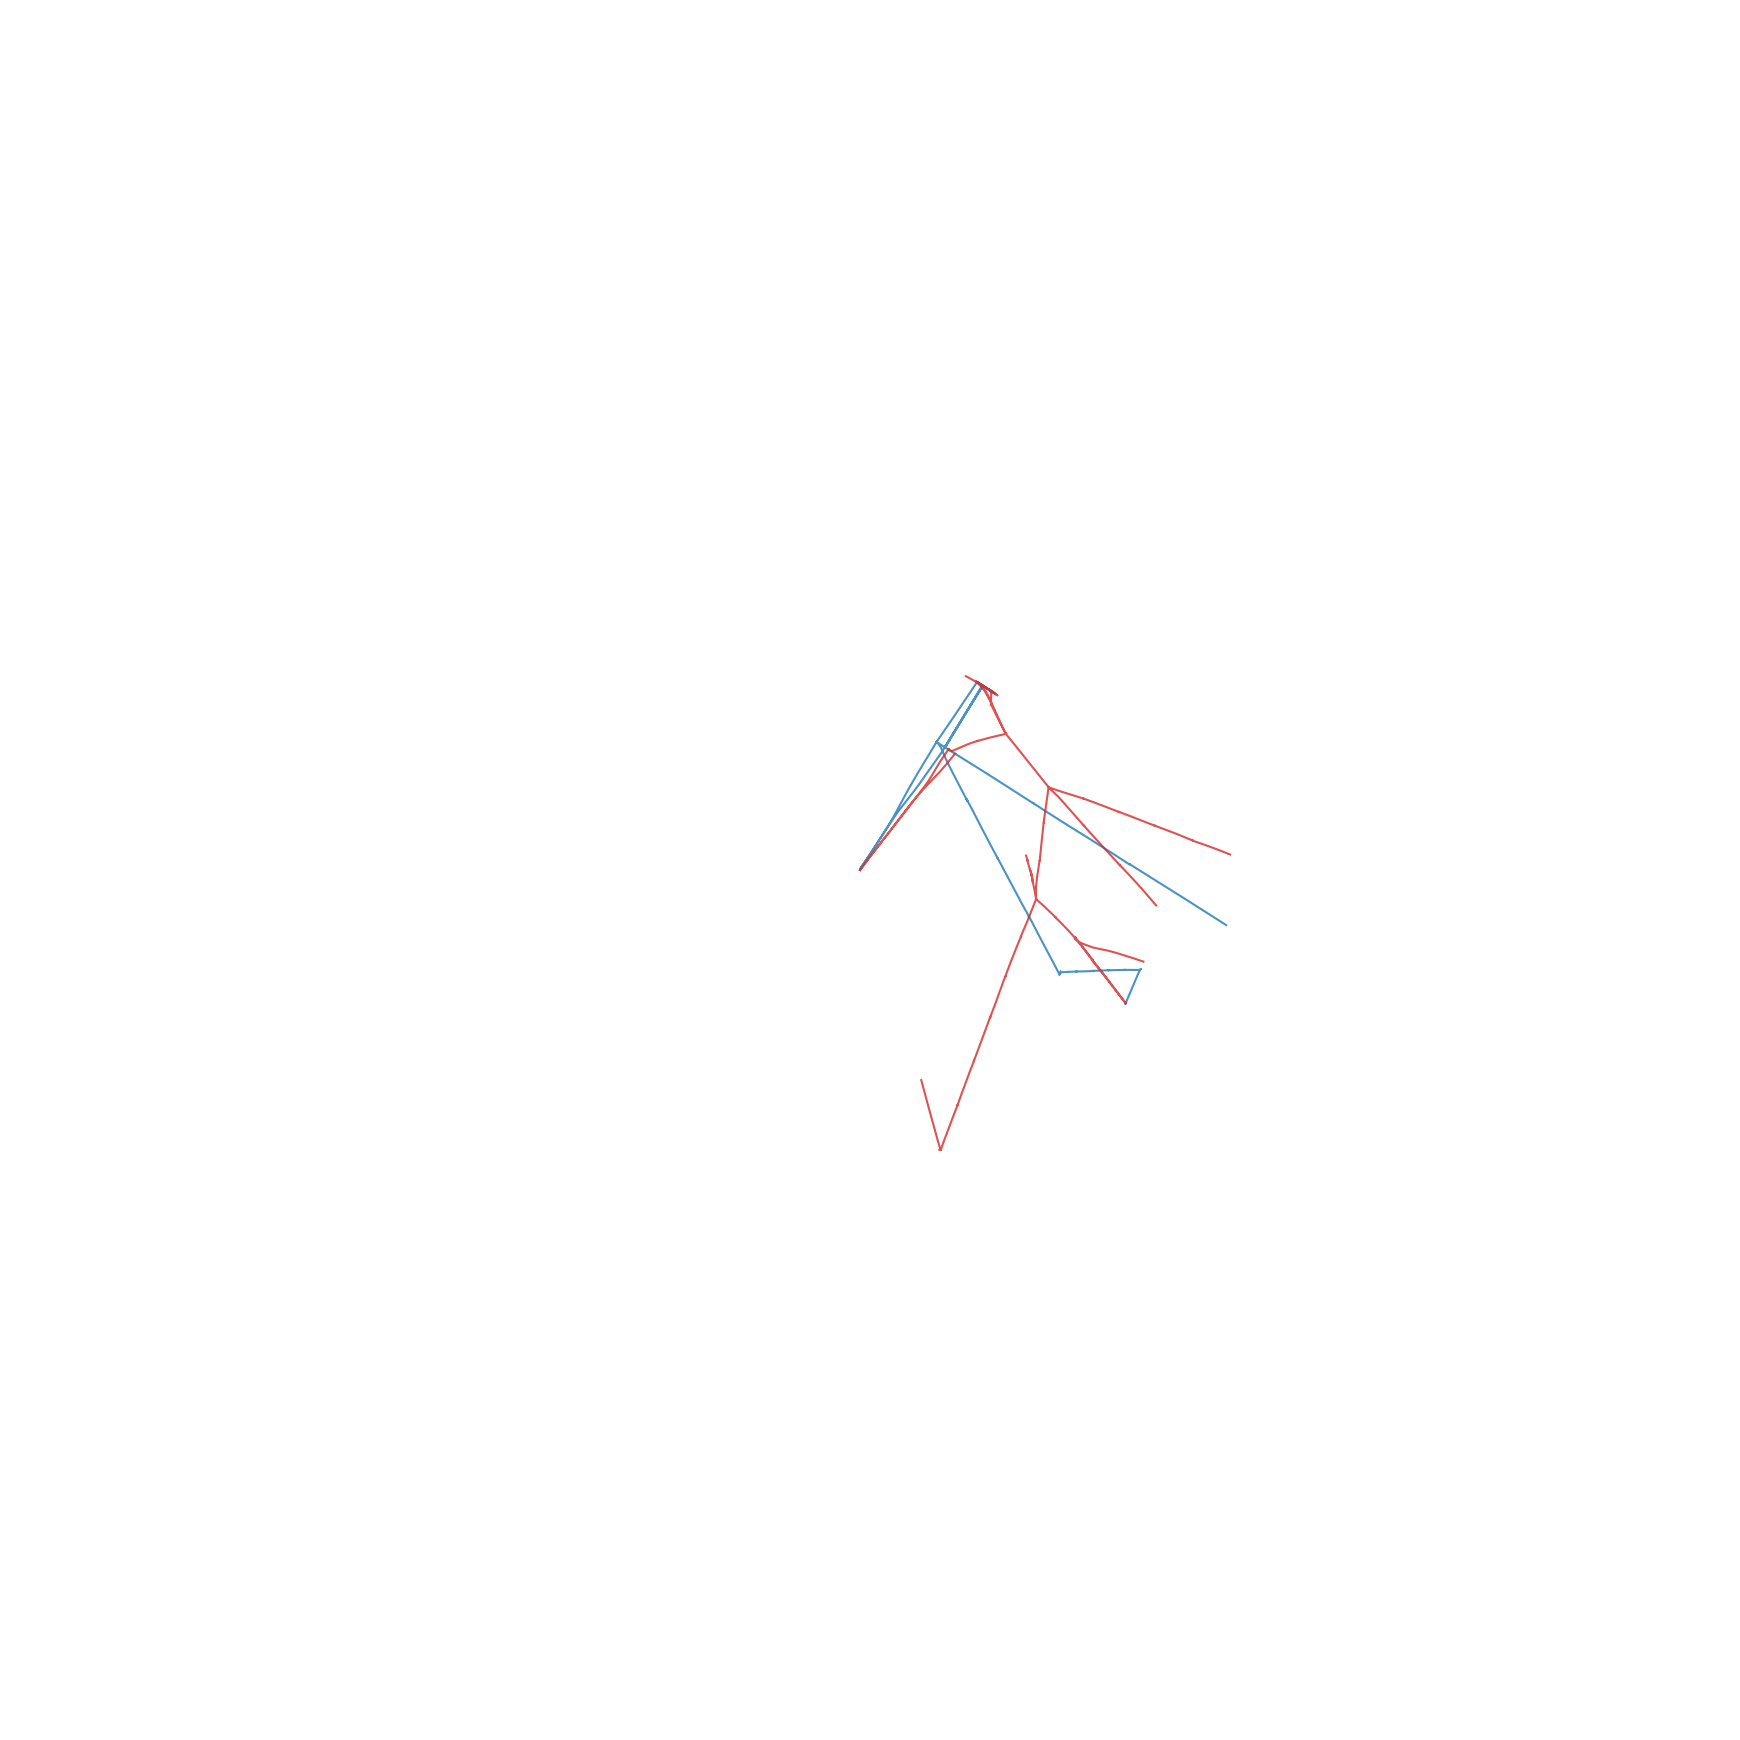

In [232]:
plot_fixed_graph2(pruned_vasc_graph_comp_male, male_wing_viz, bundle_edges=True, filename='male_wing')

# Adobe Illustrator

1. Canvas size: 1780 x 1780
2. Import female wing: 
    * X: 920
    * Y: 890
    * W: 1720
    * H: 1720
3. Import famele vascular network and do the layover
    * X: 920
    * Y: 890
    * W: 1720
    * H: 1720
4. Import the female bubbles 
5. Group the female wing and its components and mirror it 
6. Import male wing, vascular network, and bubbles